In [1]:
import os, gc, torch, PIL, pickle

import pandas as pd
from typing import List
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
# from models.load import TrainedModels
## Suppress the assignement warning from pandas.
pd.options.mode.chained_assignment = None  # default='warn

## Supress user warning
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

%matplotlib inline

In [2]:
XAMI_MIMIC_PATH = "D:\XAMI-MIMIC"

In [3]:
from enum import Enum

class TrainedModels(Enum):

    # custom_without_clinical_pretrained
    custom_without_clinical_pretrained_ar = "val_ar_0_5181_ap_0_2127_test_ar_0_5659_ap_0_2037_epoch36_WithoutClincal_04-10-2022 08-07-20_custom_without_clinical_pretrained"
    custom_without_clinical_pretrained_ap = "val_ar_0_4635_ap_0_2291_test_ar_0_5178_ap_0_1937_epoch17_WithoutClincal_04-10-2022 07-30-34_custom_without_clinical_pretrained"
    custom_without_clinical_pretrained_final = "val_ar_0_4279_ap_0_2052_test_ar_0_4103_ap_0_1757_epoch50_WithoutClincal_04-10-2022 08-34-20_custom_without_clinical_pretrained"

    # custom_with_clinical_pretrained
    custom_with_clinical_pretrained_ar = "val_ar_0_5171_ap_0_2336_test_ar_0_5267_ap_0_1545_epoch39_WithClincal_04-10-2022 10-15-22_custom_with_clinical_pretrained"
    custom_with_clinical_pretrained_ap = "val_ar_0_4581_ap_0_2496_test_ar_0_5533_ap_0_1655_epoch49_WithClincal_04-10-2022 10-38-54_custom_with_clinical_pretrained"
    custom_with_clinical_pretrained_final = "val_ar_0_3912_ap_0_1756_test_ar_0_5129_ap_0_1736_epoch50_WithClincal_04-10-2022 10-41-48_custom_with_clinical_pretrained"

    # custom_without_clinical_no_pretrained
    custom_without_clinical_no_pretrained_ar = "val_ar_0_4295_ap_0_1586_test_ar_0_4991_ap_0_2054_epoch39_WithoutClincal_04-10-2022 12-02-33_custom_without_clinical_no_pretrained"
    custom_without_clinical_no_pretrained_ap = "val_ar_0_4156_ap_0_1726_test_ar_0_5085_ap_0_1841_epoch40_WithoutClincal_04-10-2022 12-05-11_custom_without_clinical_no_pretrained"
    custom_without_clinical_no_pretrained_final = "val_ar_0_2427_ap_0_1189_test_ar_0_3630_ap_0_1724_epoch50_WithoutClincal_04-10-2022 12-25-02_custom_without_clinical_no_pretrained"

    # custom_with_clinical_no_pretrained
    custom_with_clinical_no_pretrained_ar = "val_ar_0_4338_ap_0_2249_test_ar_0_4445_ap_0_1816_epoch49_WithClincal_04-10-2022 14-24-02_custom_with_clinical_no_pretrained"
    custom_with_clinical_no_pretrained_ap = "val_ar_0_4338_ap_0_2249_test_ar_0_4445_ap_0_1816_epoch49_WithClincal_04-10-2022 14-24-04_custom_with_clinical_no_pretrained"
    custom_with_clinical_no_pretrained_final = "val_ar_0_3519_ap_0_1750_test_ar_0_4113_ap_0_1602_epoch50_WithClincal_04-10-2022 14-27-02_custom_with_clinical_no_pretrained"

    # custom_without_clinical_swim
    custom_without_clinical_swim_ar = "val_ar_0_4324_ap_0_1400_test_ar_0_4371_ap_0_1408_epoch45_WithoutClincal_04-10-2022 16-09-22_custom_with_clinical_swim"
    custom_without_clinical_swim_ap = "val_ar_0_3653_ap_0_1552_test_ar_0_3867_ap_0_1298_epoch29_WithoutClincal_04-10-2022 15-34-21_custom_with_clinical_swim"
    custom_without_clinical_swim_final = "val_ar_0_3816_ap_0_1417_test_ar_0_3788_ap_0_1313_epoch50_WithoutClincal_04-10-2022 16-20-24_custom_with_clinical_swim"

    # custom_with_clinical_swim
    custom_with_clinical_swim_ar = "val_ar_0_4182_ap_0_1406_test_ar_0_4256_ap_0_0967_epoch44_WithClincal_04-10-2022 18-17-49_custom_with_clinical_swim"
    custom_with_clinical_swim_ap = "val_ar_0_3589_ap_0_1554_test_ar_0_4126_ap_0_1312_epoch41_WithClincal_04-10-2022 18-09-37_custom_with_clinical_swim"
    custom_with_clinical_swim_final = "val_ar_0_3008_ap_0_0923_test_ar_0_3878_ap_0_1092_epoch50_WithClincal_04-10-2022 18-33-30_custom_with_clinical_swim"



In [4]:
get_epoch_from_model = lambda select_model: int(([substr for substr in select_model.value.split("_") if "epoch" in substr][0]).replace("epoch", ""))
get_model_name = lambda select_model: str(select_model).split(".")[-1]
get_model_label = lambda select_model: get_model_name(select_model) + f" (epoch: {get_epoch_from_model(select_model)})" 

def get_dataset_label(dataset, select_model):
    return dataset + f" (epoch: {get_epoch_from_model(select_model)})"

In [5]:
def get_thrs_evaluation_df(models: List[TrainedModels] , suffix, disease="all", thrs = 0.5,):
    
    all_models_eval_data = {}
    for select_model in models:
        with open(
            os.path.join(
                "eval_results",
                f"{select_model.value}_{suffix}_{disease}.pkl",
            ),
            "rb",
        ) as f:
            eval_data = pickle.load(f)
            all_models_eval_data[select_model.value] = eval_data

    return  pd.DataFrame(
            [
                {
                    "model": str(select_model).split(".")[-1],
                    **all_models_eval_data[select_model.value][thrs][0],
                } for select_model in models
            ]
        )[['model','ap', 'ar']]

In [6]:
from models.load import TrainedModels
from typing import List

def plot_iou_result(models: List[TrainedModels] , suffix, disease="all", figsize=(10, 10)):

    cm = plt.get_cmap('rainbow')
    NUM_COLORS = len(models)

    all_models_eval_data = {}
    for select_model in models:
        with open(
            os.path.join(
                "eval_results",
                f"{select_model.value}_{suffix}_{disease}.pkl",
            ),
            "rb",
        ) as f:
            eval_data = pickle.load(f)
            all_models_eval_data[select_model.value] = eval_data


    fig, (precision_ax, recall_ax) = plt.subplots(
        2, figsize=figsize, dpi=80, sharex=True,
    )

    fig.suptitle(f"{suffix}")

    precision_ax.set_title("Average Precision")
    precision_ax.set_prop_cycle('color', [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

    for select_model in models:
        precision_ax.plot(
            all_models_eval_data[select_model.value].keys(),
            [v[0]["ap"] for v in all_models_eval_data[select_model.value].values()],
            marker="o",
            label=get_model_label(select_model),
            # color="darkorange",
        )
    precision_ax.legend(loc="upper right")

    recall_ax.set_title("Average Recall")
    recall_ax.set_prop_cycle('color', [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
    
    for select_model in models:
        recall_ax.plot(
            all_models_eval_data[select_model.value].keys(),
            [v[0]["ar"] for v in all_models_eval_data[select_model.value].values()],
            marker="o",
            label=get_model_label(select_model),
            # color="darkorange",
        )

    recall_ax.legend(loc="upper right")
    recall_ax.set_xlabel("IoBB")

    plt.plot()
    plt.pause(0.01)

    return fig

In [7]:
def showModelOnDatasets(select_model, datasets, disease="all", figsize=(10, 10)):
    '''
    This function used for detecting the overfitting dataset.    
    '''
    cm = plt.get_cmap('gist_rainbow')
    NUM_COLORS = len(datasets)

    all_models_eval_data = {}
    for dataset in datasets:
        with open(
            os.path.join(
                "eval_results",
                f"{select_model.value}_{dataset}_{disease}.pkl",
            ),
            "rb",
        ) as f:
            eval_data = pickle.load(f)
            all_models_eval_data[dataset] = eval_data


    fig, (precision_ax, recall_ax) = plt.subplots(
        2, figsize=figsize, dpi=80, sharex=True,
    )

    fig.suptitle(get_model_label(select_model))

    precision_ax.set_title("Average Precision")
    precision_ax.set_prop_cycle('color', [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

    for dataset in datasets:
        precision_ax.plot(
            all_models_eval_data[dataset].keys(),
            [v[0]["ap"] for v in all_models_eval_data[dataset].values()],
            marker="o",
            label=dataset,
            # color="darkorange",
        )
    precision_ax.legend(loc="upper right")

    recall_ax.set_title("Average Recall")
    recall_ax.set_prop_cycle('color', [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

    for dataset in datasets:
        recall_ax.plot(
            all_models_eval_data[dataset].keys(),
            [v[0]["ar"] for v in all_models_eval_data[dataset].values()],
            marker="o",
            label=dataset,
            # color="darkorange",
        )

    recall_ax.legend(loc="upper right")
    recall_ax.set_xlabel("IoBB")

    plt.plot()
    plt.pause(0.01)

    return fig


## Show the all the reuslts in single figure, then we will analysis different variables in laters sectinos.

In [8]:
df = get_thrs_evaluation_df(TrainedModels, "train", thrs=0.5)
df.sort_values("ap", ascending=False)

### highest AP: custom_without_clinical_pretrained_final (0.347963)

## After some researching: SwinTransformer is not ideal in this case, since it tend to perfrom better in a larger dataset.
## Pretrained model perform better.

model        ap        ar
2      custom_without_clinical_pretrained_final  0.347963  0.608305
0         custom_without_clinical_pretrained_ar  0.332149  0.593956
5         custom_with_clinical_pretrained_final  0.252565  0.499913
4            custom_with_clinical_pretrained_ap  0.237855  0.512479
3            custom_with_clinical_pretrained_ar  0.201566  0.479387
1         custom_without_clinical_pretrained_ap  0.179155  0.403762
10        custom_with_clinical_no_pretrained_ap  0.122946  0.346303
9         custom_with_clinical_no_pretrained_ar  0.115190  0.331287
6      custom_without_clinical_no_pretrained_ar  0.113646  0.361855
8   custom_without_clinical_no_pretrained_final  0.112939  0.259411
11     custom_with_clinical_no_pretrained_final  0.103611  0.313202
7      custom_without_clinical_no_pretrained_ap  0.100801  0.349403
14           custom_without_clinical_swim_final  0.092273  0.289567
12              custom_without_clinical_swim_ar  0.091829  0.327441
16                 custom_with_clinical_swim_ap  0.079439  0.298930
13              custom_without_clinical_swim_ap  0.076498  0.278094
17              custom_with_clinical_swim_final  0.072670  0.293100
15                 custom_with_clinical_swim_ar  0.070872  0.318525

In [9]:
df = get_thrs_evaluation_df(TrainedModels, "val", thrs=0.5)
df.sort_values("ap", ascending=False)

### highest AP: custom_with_clinical_pretrained_ap (0.248162)

model        ap        ar
4            custom_with_clinical_pretrained_ap  0.248162  0.458103
3            custom_with_clinical_pretrained_ar  0.233591  0.517053
1         custom_without_clinical_pretrained_ap  0.229597  0.463467
9         custom_with_clinical_no_pretrained_ar  0.224865  0.433823
10        custom_with_clinical_no_pretrained_ap  0.224865  0.433823
0         custom_without_clinical_pretrained_ar  0.212702  0.518125
2      custom_without_clinical_pretrained_final  0.205152  0.427894
5         custom_with_clinical_pretrained_final  0.175576  0.391248
11     custom_with_clinical_no_pretrained_final  0.175034  0.351892
7      custom_without_clinical_no_pretrained_ap  0.173148  0.415641
6      custom_without_clinical_no_pretrained_ar  0.158616  0.429531
16                 custom_with_clinical_swim_ap  0.155439  0.358893
13              custom_without_clinical_swim_ap  0.155224  0.365274
14           custom_without_clinical_swim_final  0.141674  0.381649
15                 custom_with_clinical_swim_ar  0.140626  0.418238
12              custom_without_clinical_swim_ar  0.139977  0.432411
8   custom_without_clinical_no_pretrained_final  0.118920  0.242688
17              custom_with_clinical_swim_final  0.095367  0.300847

In [10]:
df = get_thrs_evaluation_df(TrainedModels, "test", thrs=0.5)
df.sort_values("ap", ascending=False)

### highest AP: custom_without_clinical_no_pretrained_ar (0.205445)

model        ap        ar
6      custom_without_clinical_no_pretrained_ar  0.205445  0.499141
0         custom_without_clinical_pretrained_ar  0.203692  0.565932
1         custom_without_clinical_pretrained_ap  0.191092  0.508251
7      custom_without_clinical_no_pretrained_ap  0.183940  0.508510
10        custom_with_clinical_no_pretrained_ap  0.182022  0.444510
9         custom_with_clinical_no_pretrained_ar  0.182022  0.444510
2      custom_without_clinical_pretrained_final  0.175735  0.410255
5         custom_with_clinical_pretrained_final  0.173560  0.512893
8   custom_without_clinical_no_pretrained_final  0.172397  0.363004
4            custom_with_clinical_pretrained_ap  0.165456  0.553267
11     custom_with_clinical_no_pretrained_final  0.160211  0.411321
3            custom_with_clinical_pretrained_ar  0.154453  0.526727
12              custom_without_clinical_swim_ar  0.140836  0.437069
16                 custom_with_clinical_swim_ap  0.133390  0.412603
14           custom_without_clinical_swim_final  0.131347  0.378840
13              custom_without_clinical_swim_ap  0.126633  0.386658
17              custom_with_clinical_swim_final  0.108902  0.387849
15                 custom_with_clinical_swim_ar  0.096711  0.425595

### Plotting the curve will be easier for comparing the models.

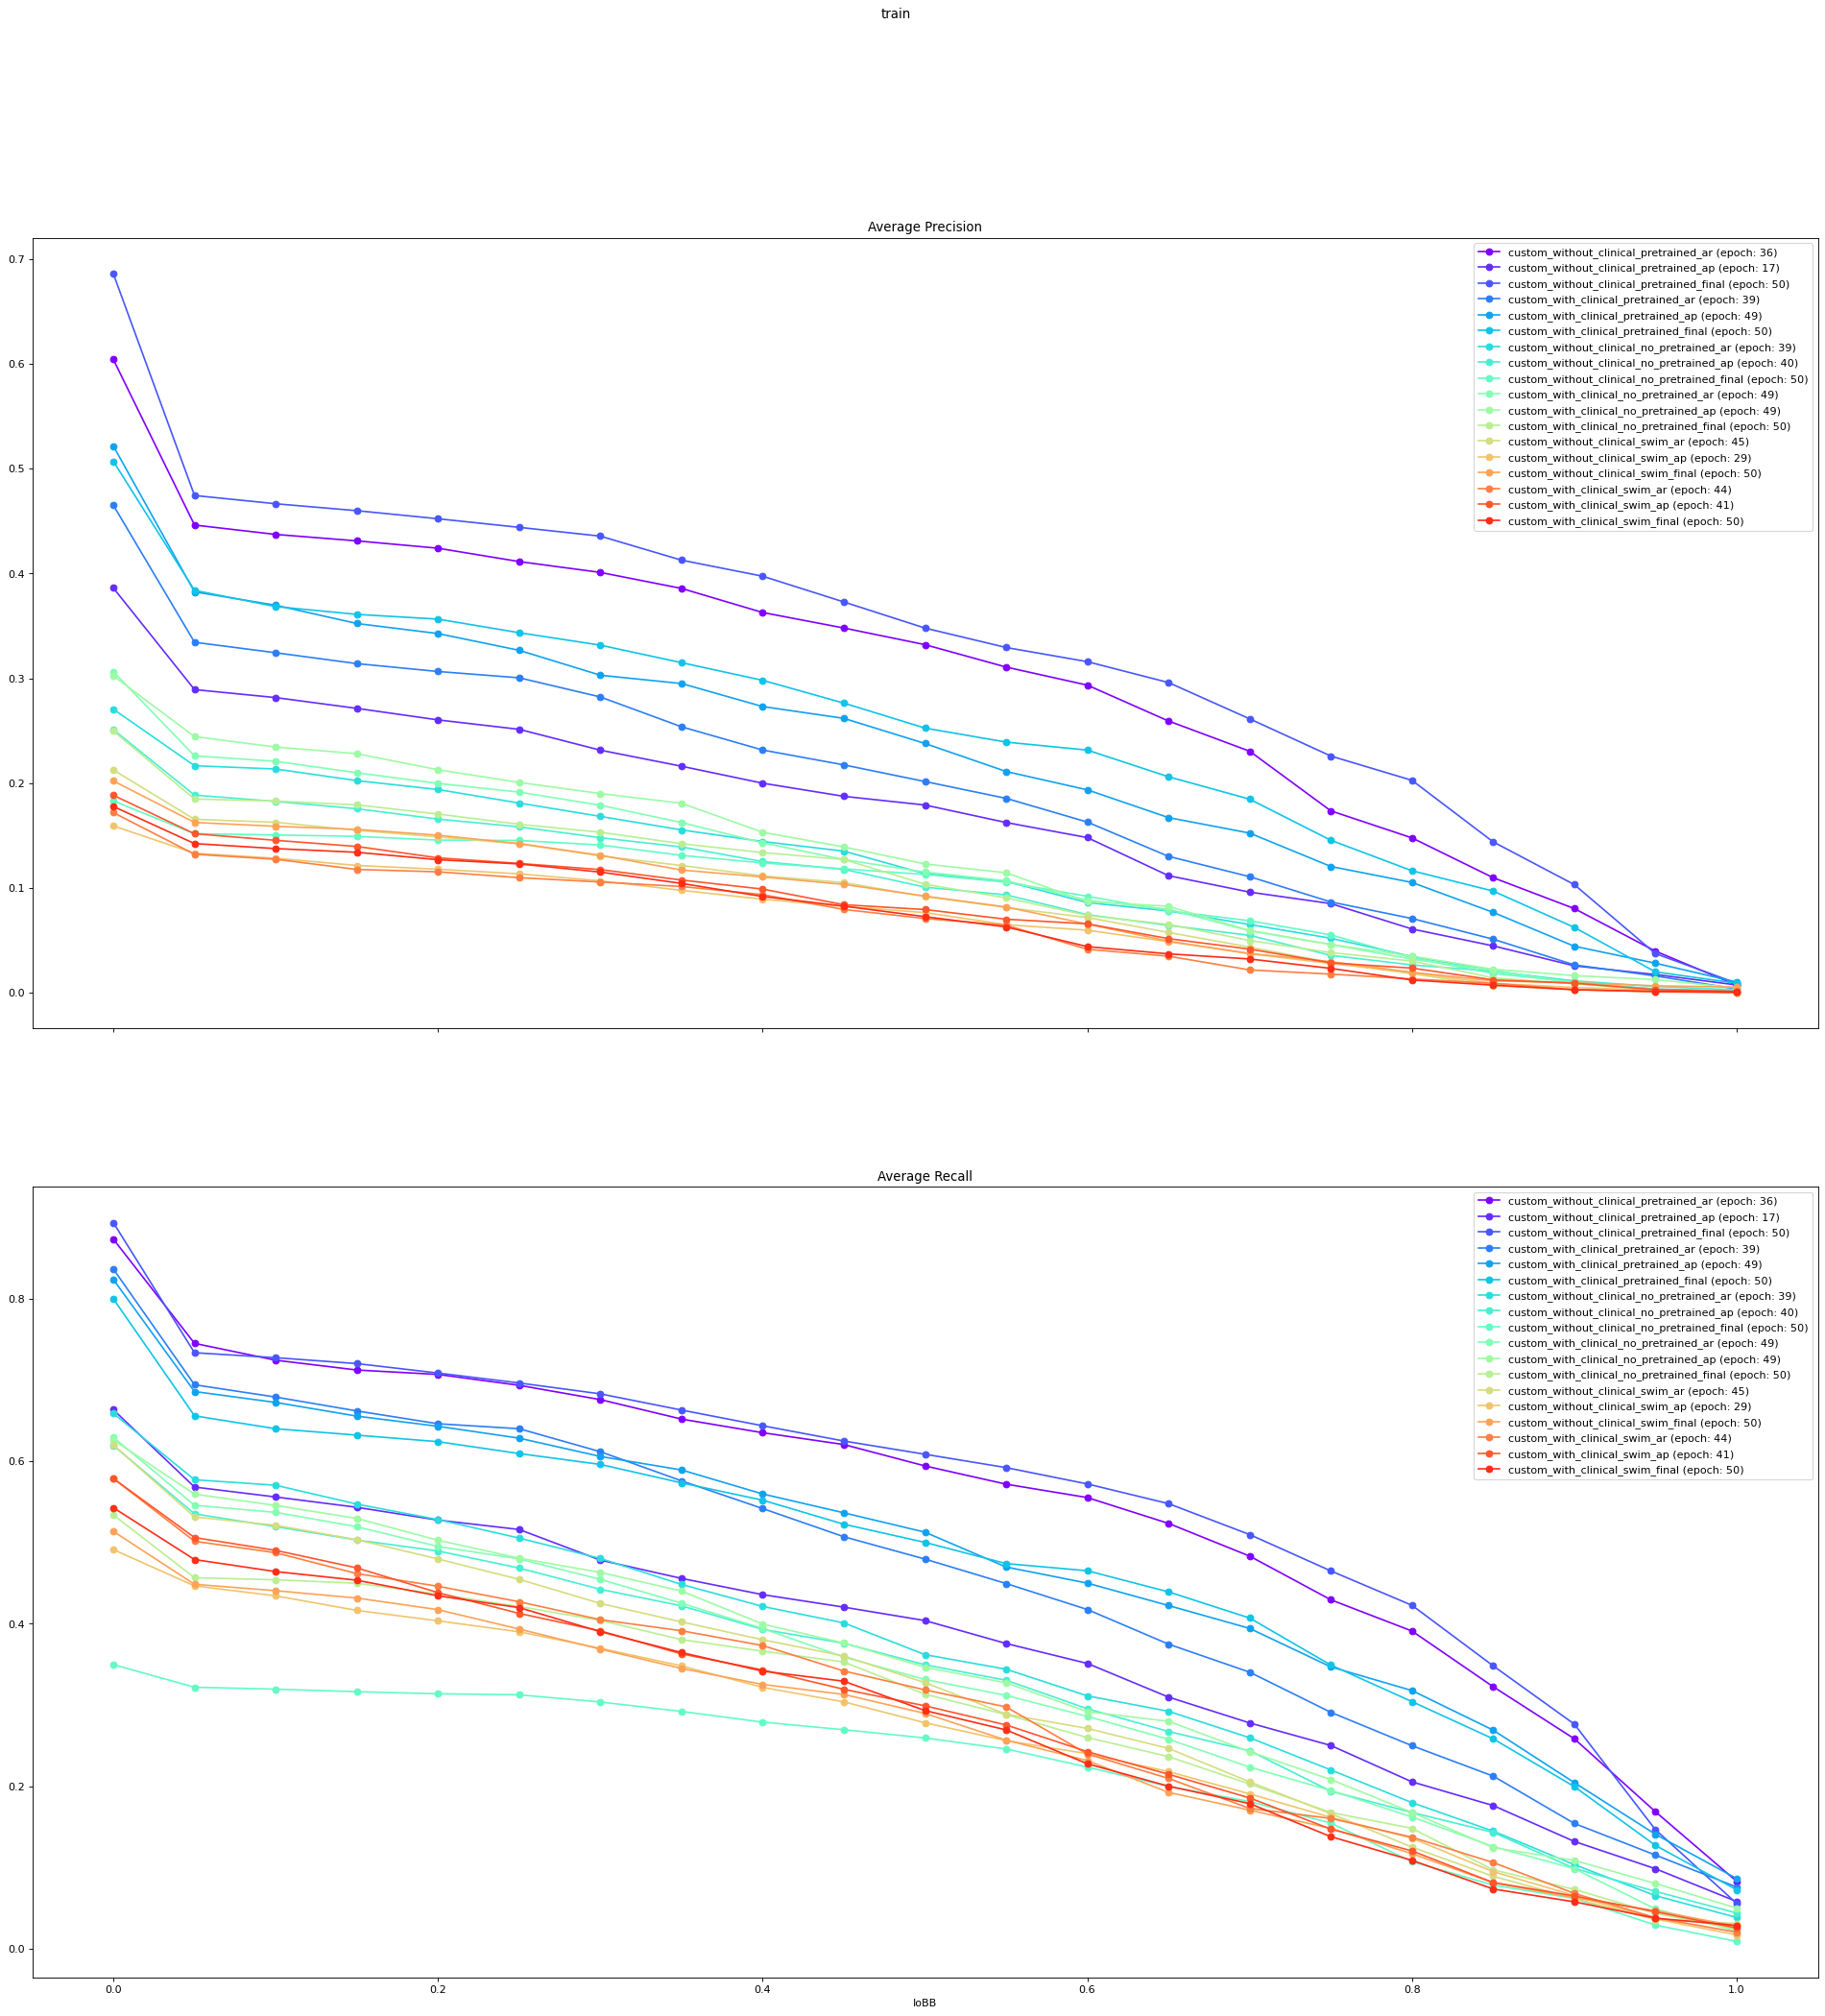

In [11]:
_ = plot_iou_result(TrainedModels, "train", figsize=(30, 30))

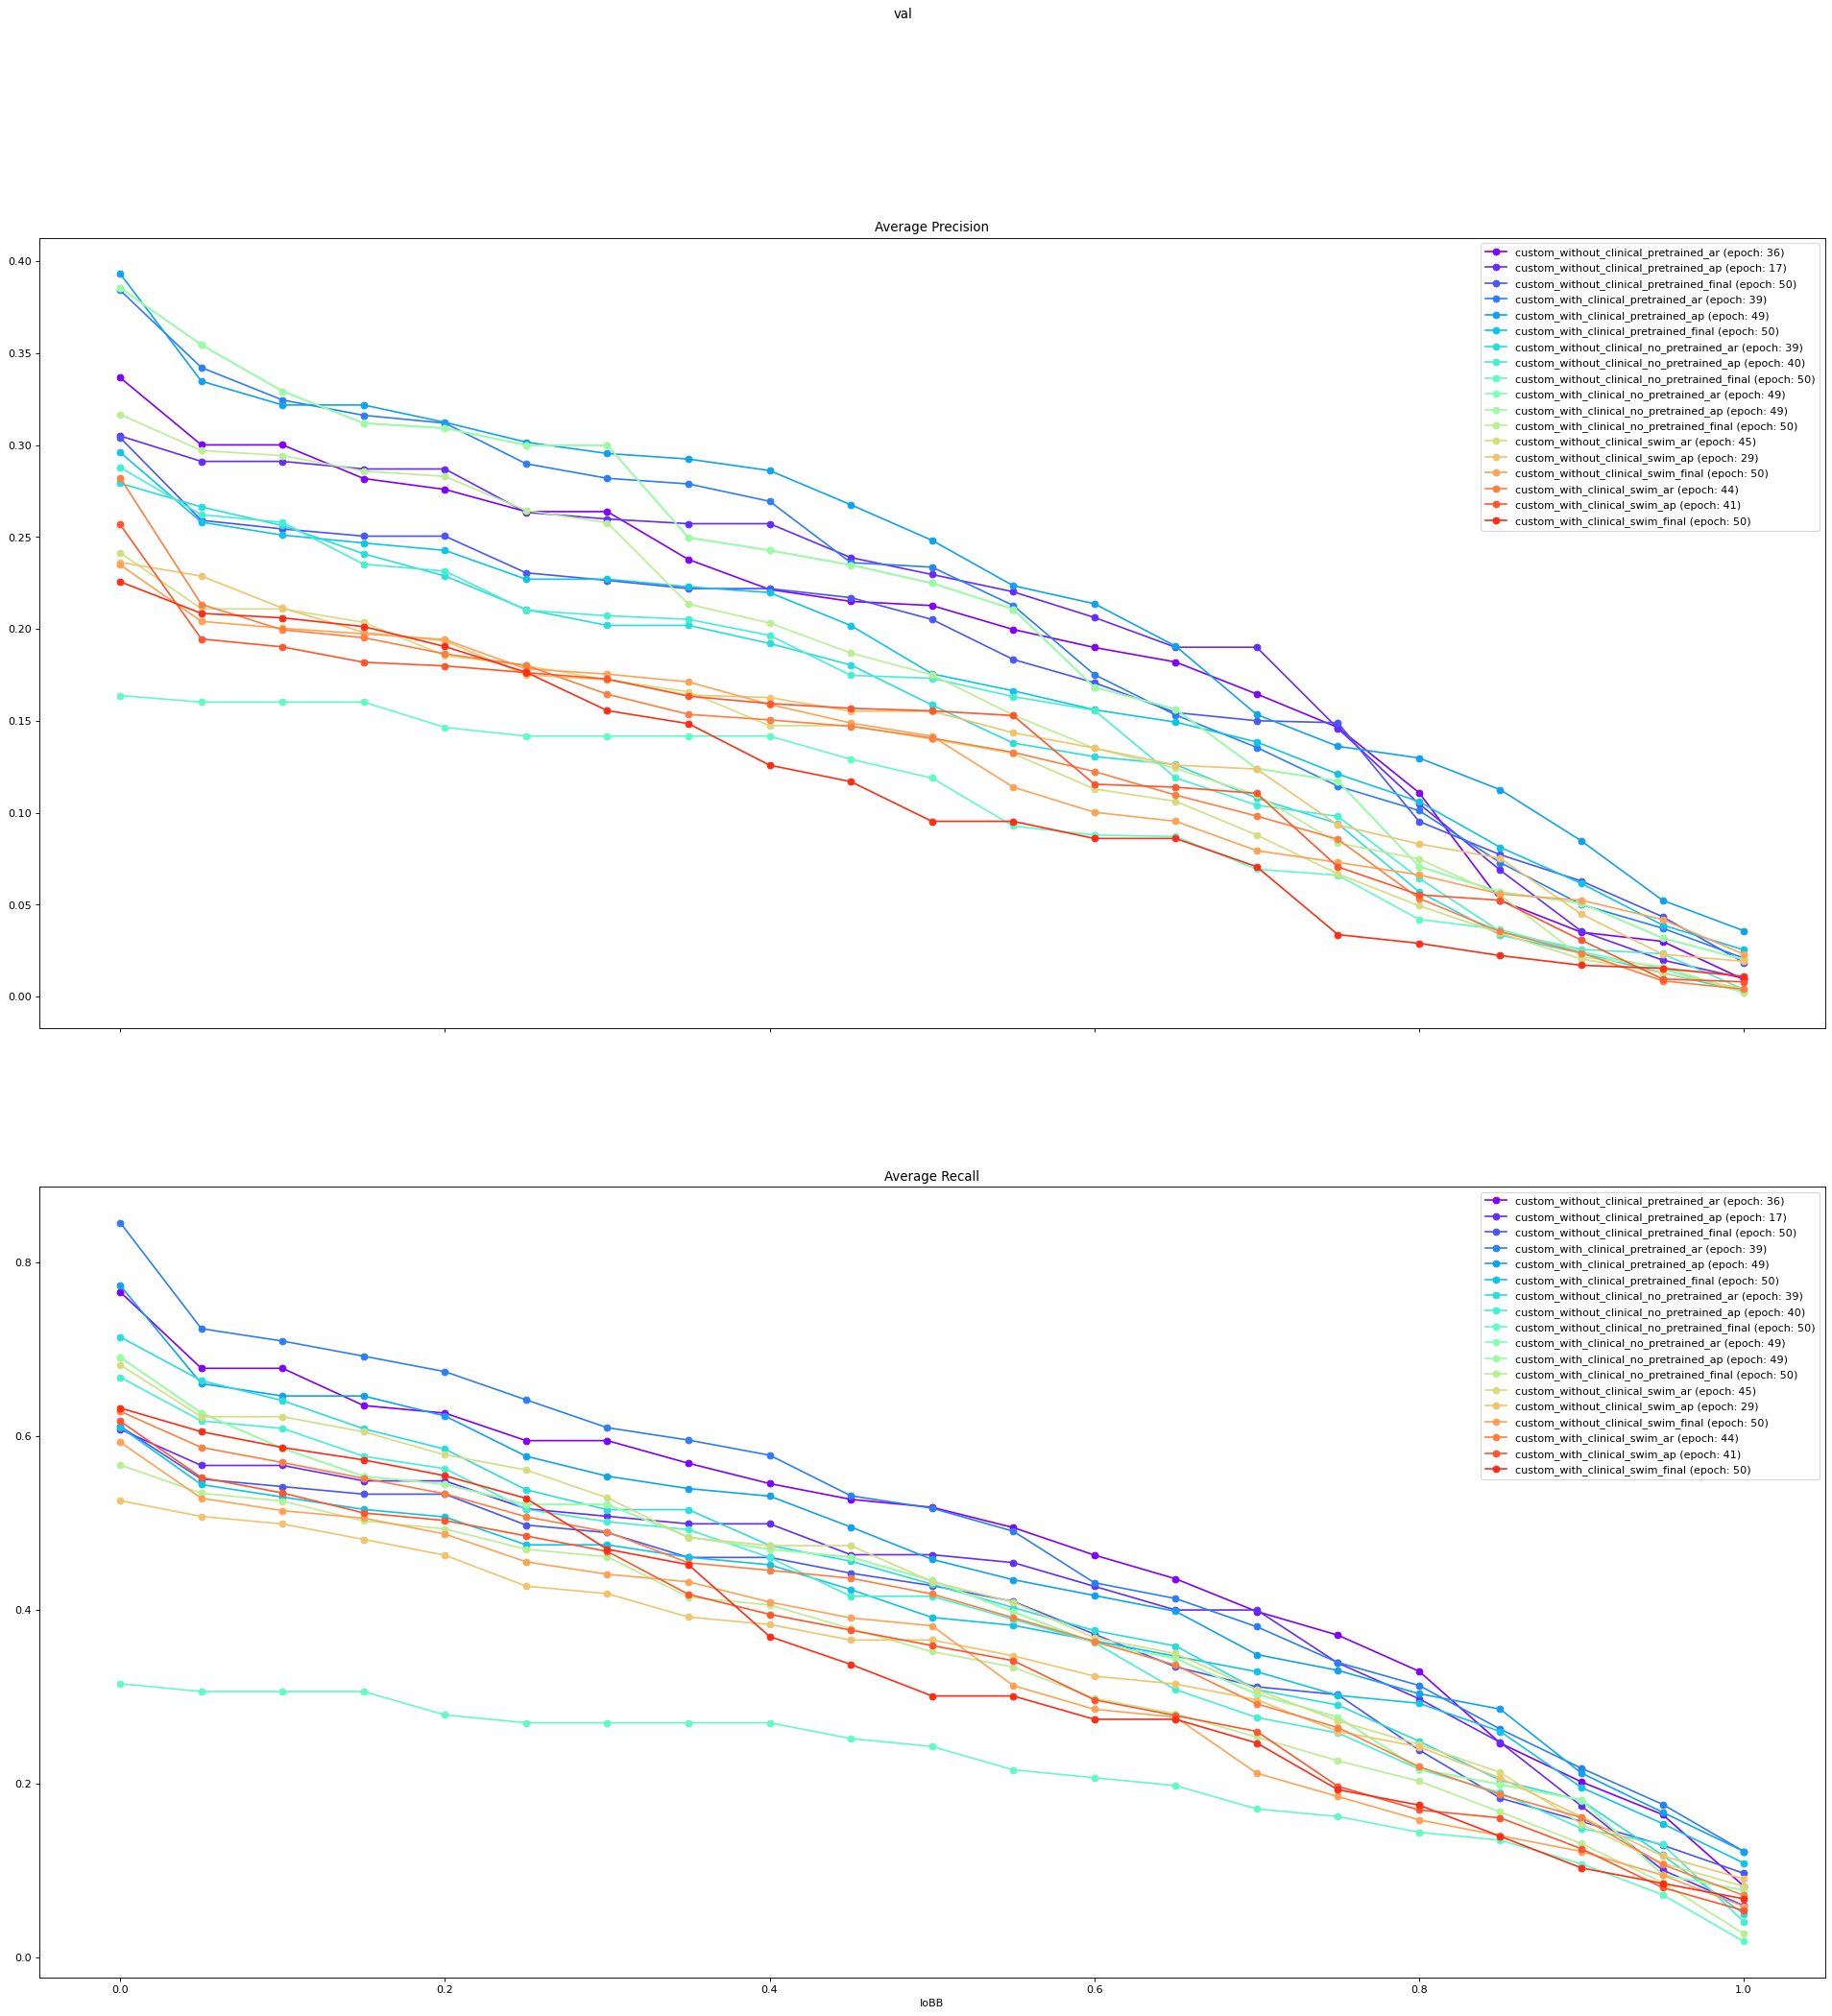

In [12]:
_ = plot_iou_result(TrainedModels, "val", figsize=(30, 30))

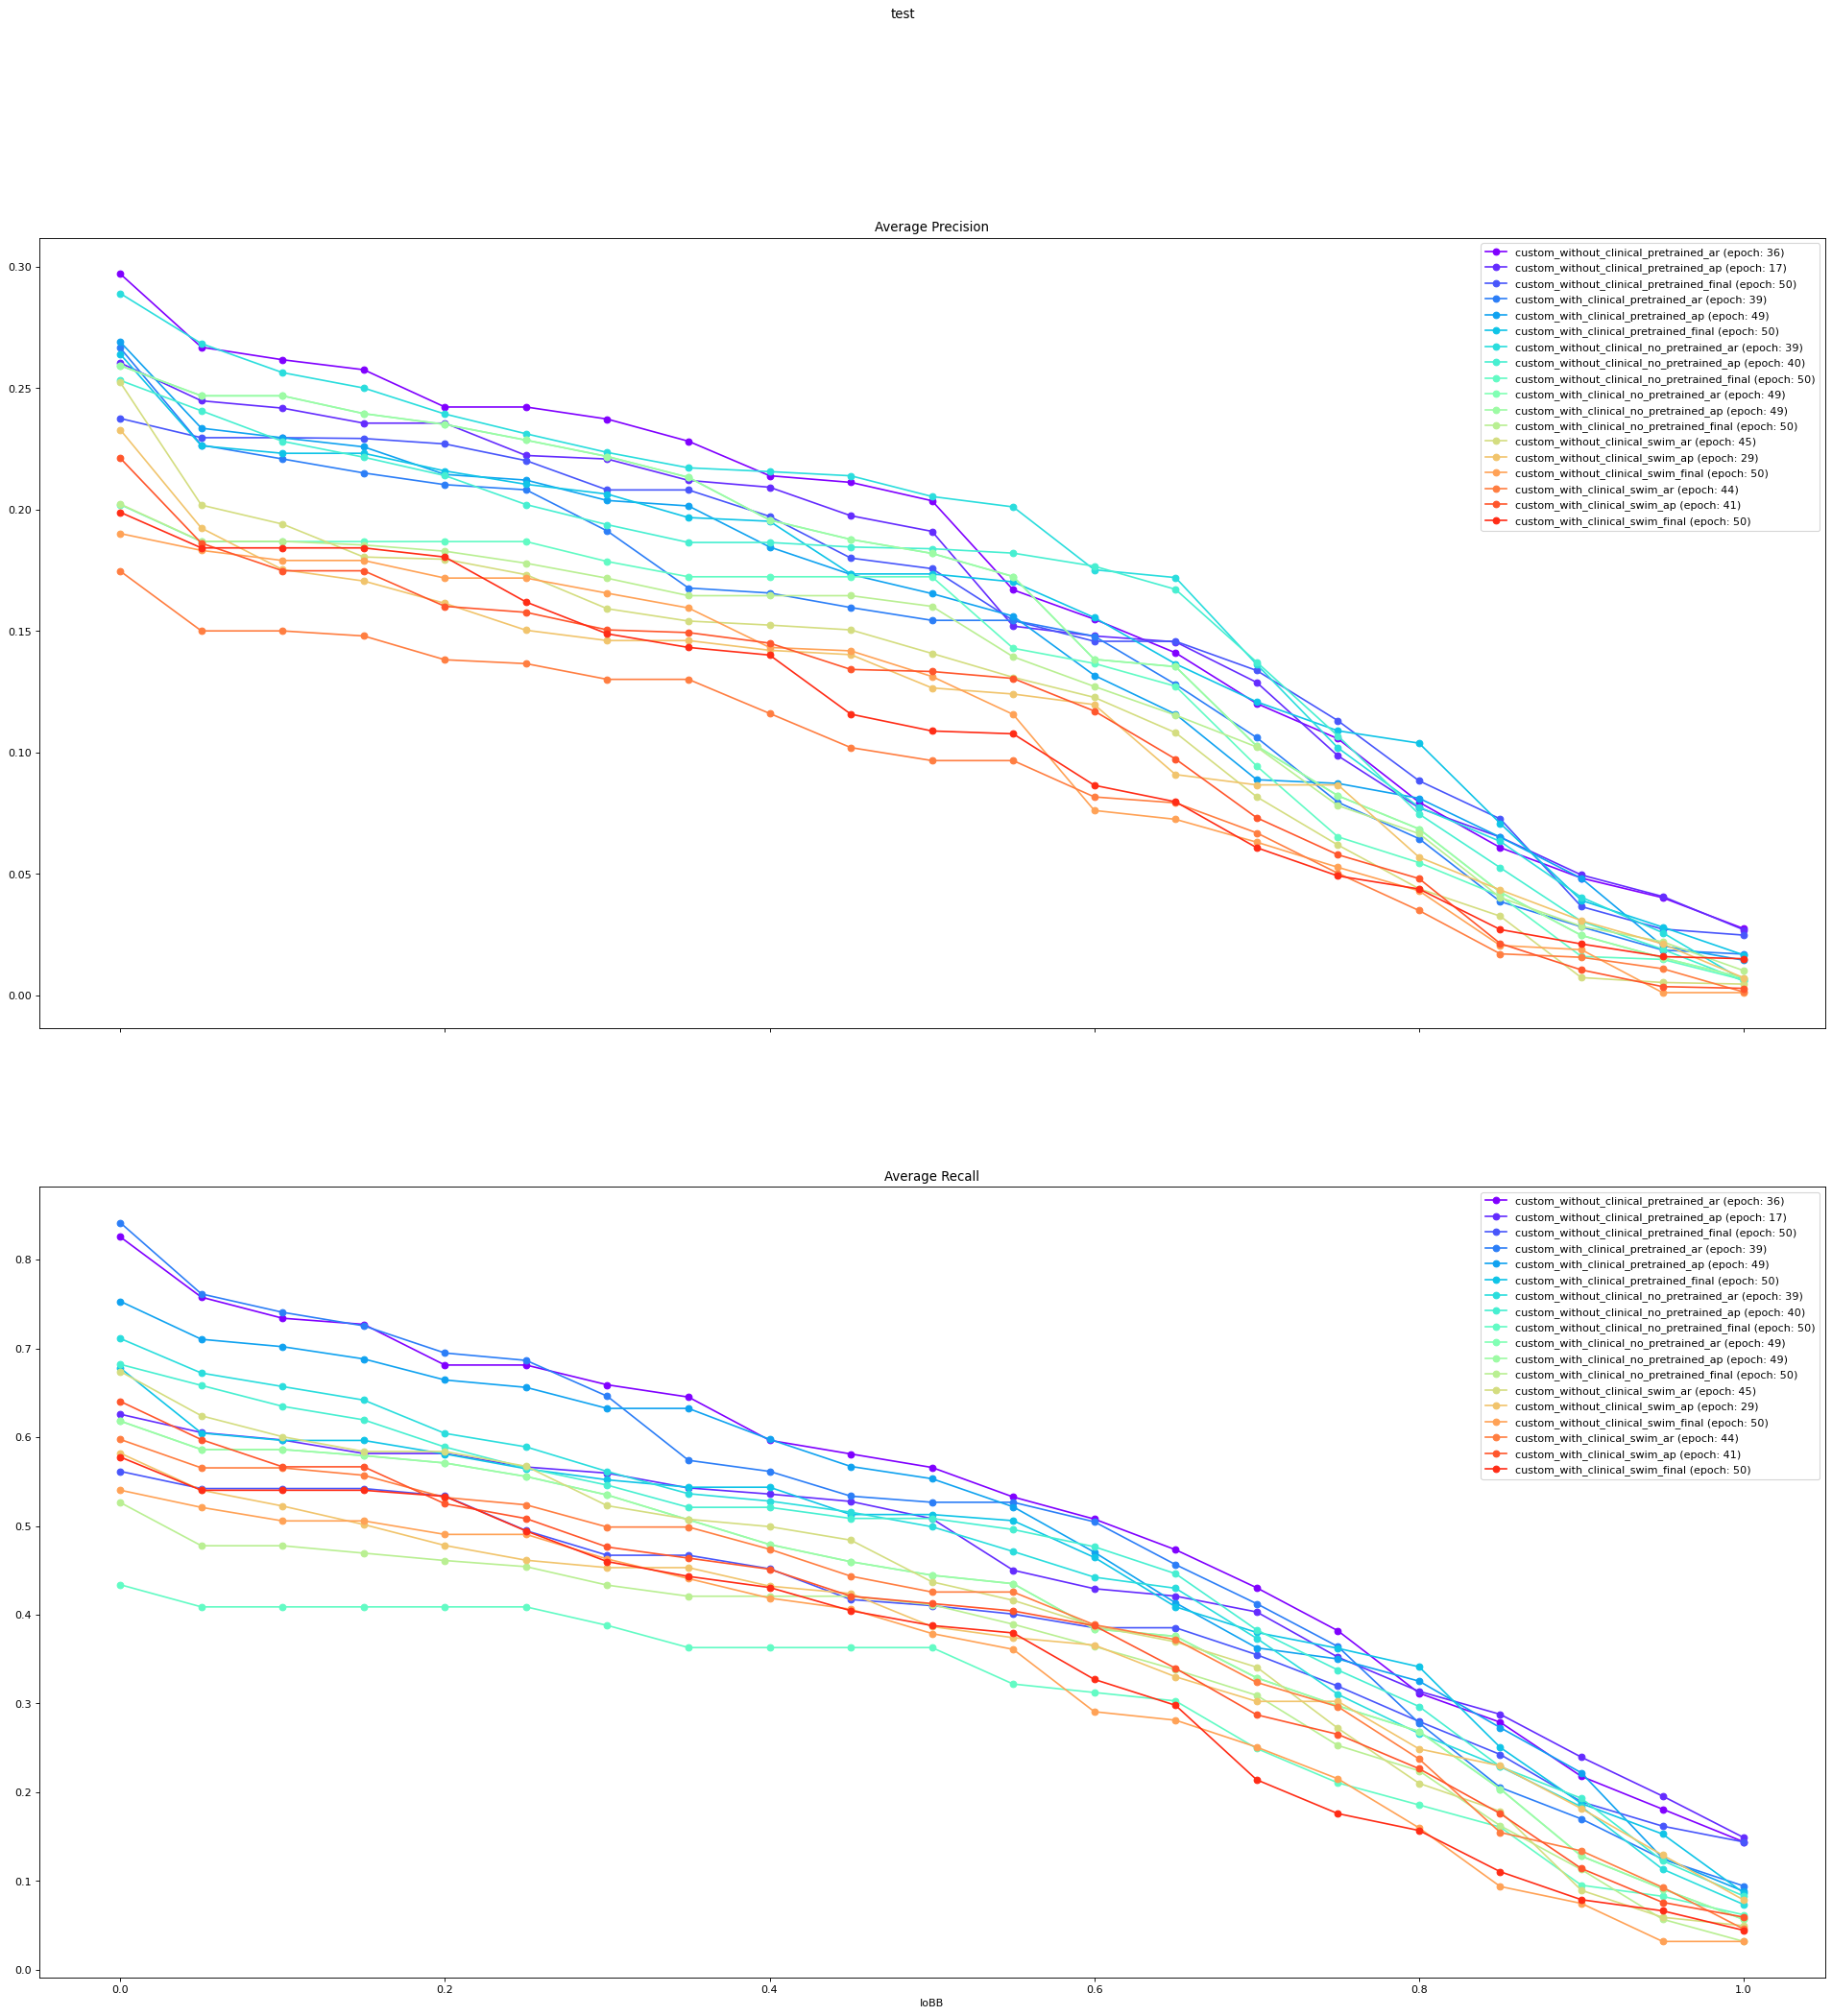

In [13]:
_ = plot_iou_result(TrainedModels, "test", figsize=(30, 30))

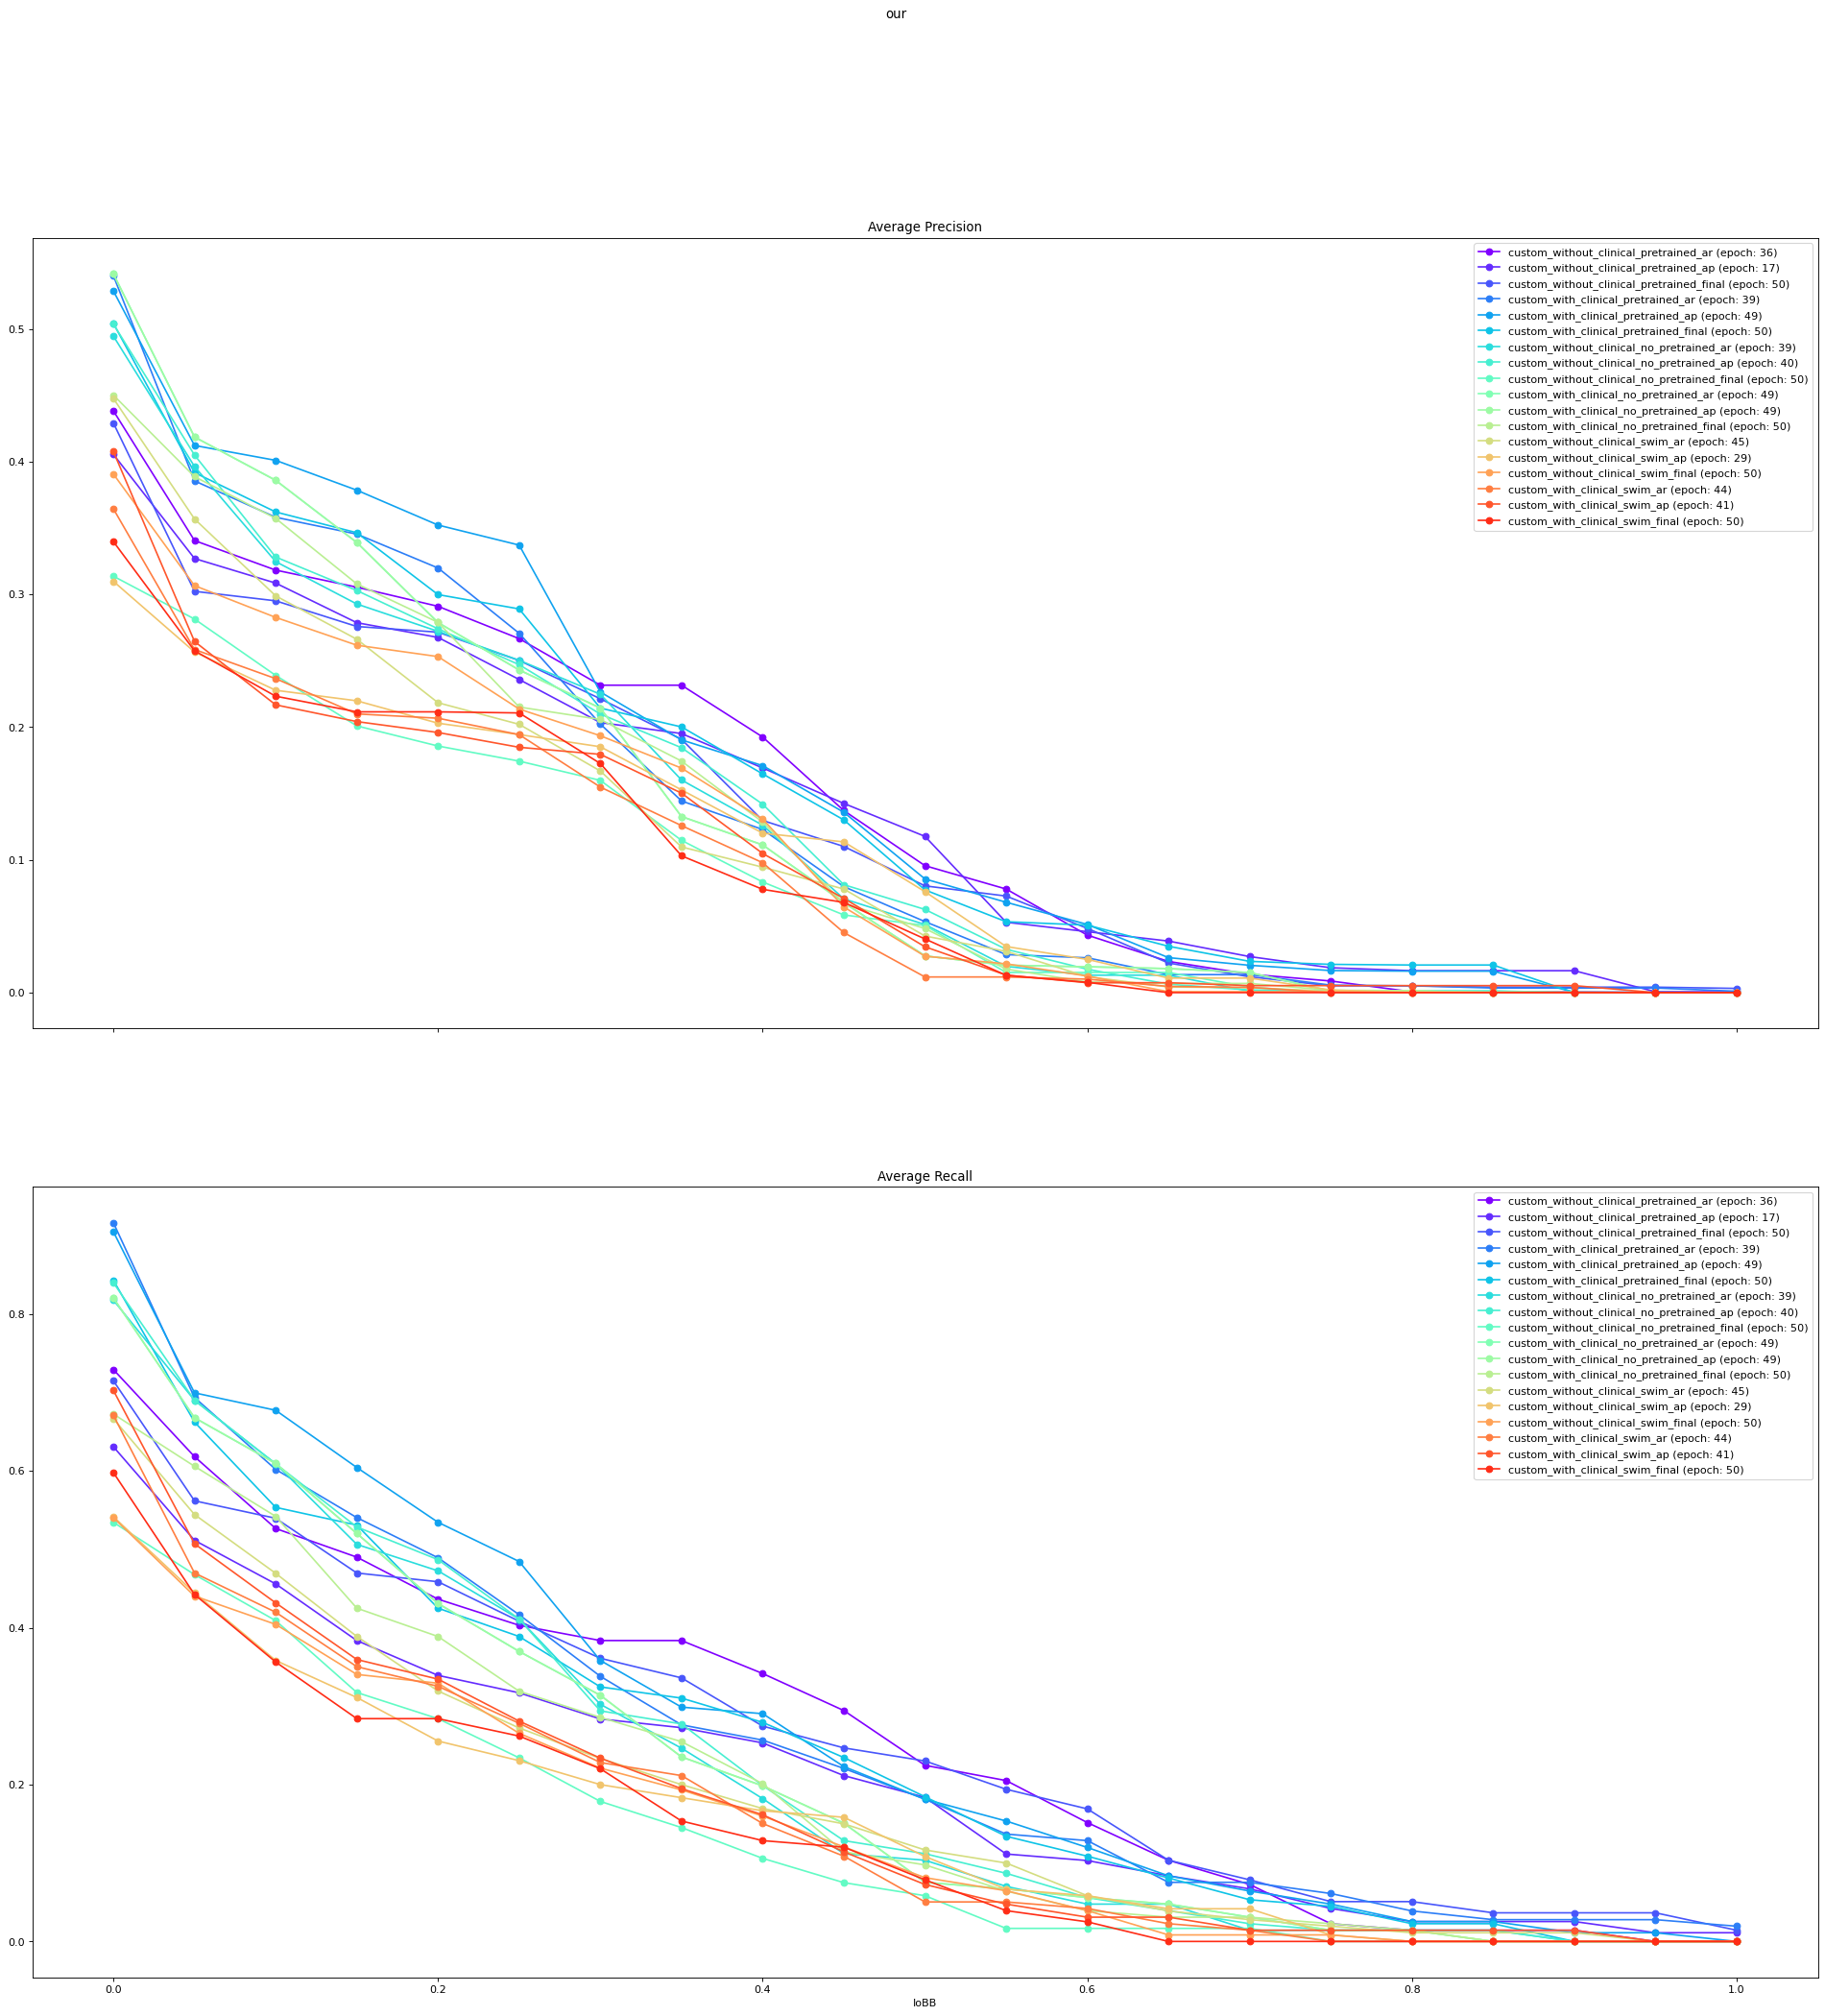

In [14]:
_ = plot_iou_result(TrainedModels, "our", figsize=(30, 30))

# See the overfitting on each model.

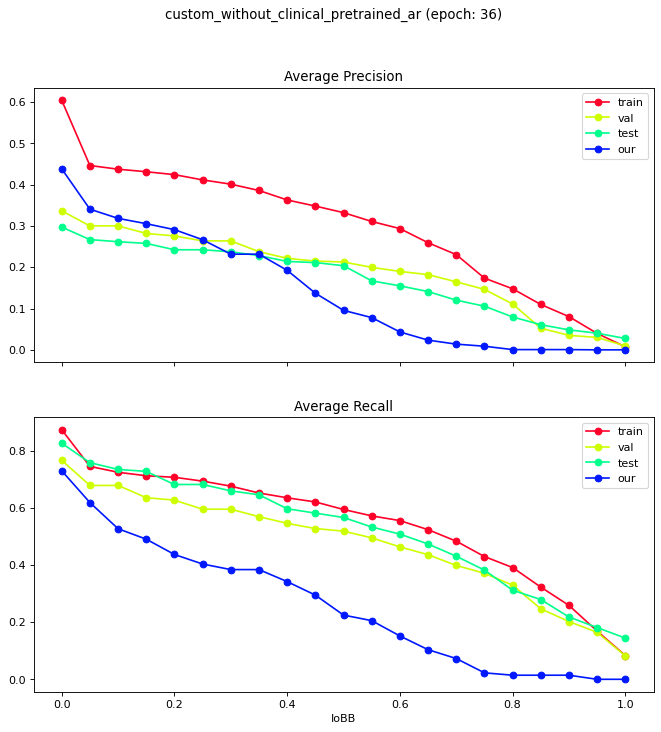

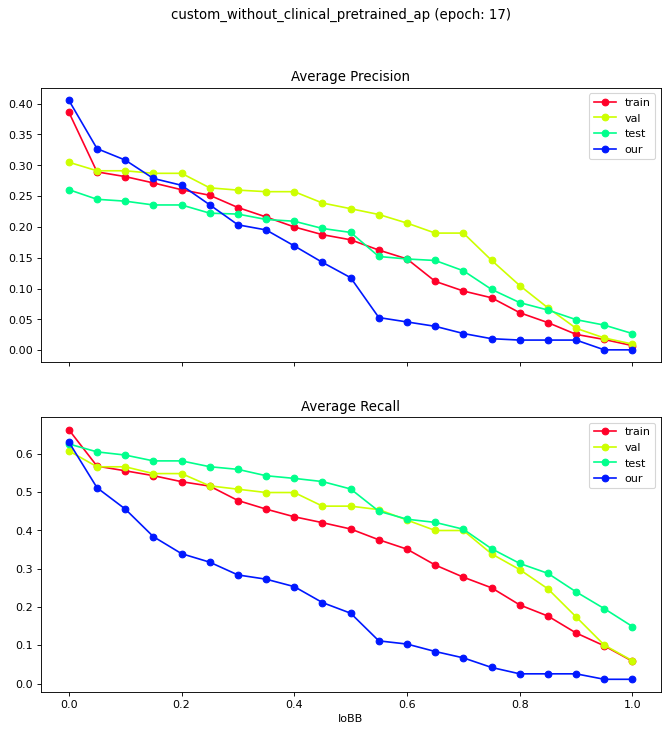

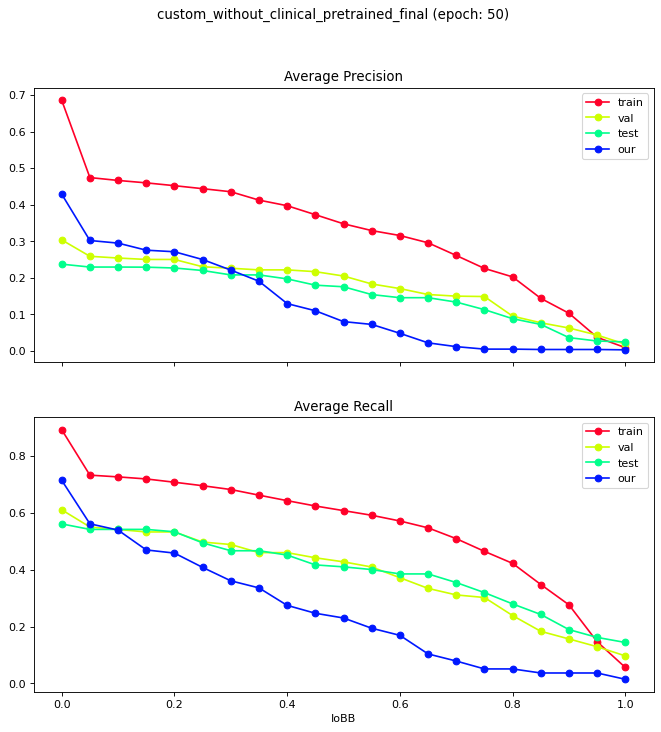

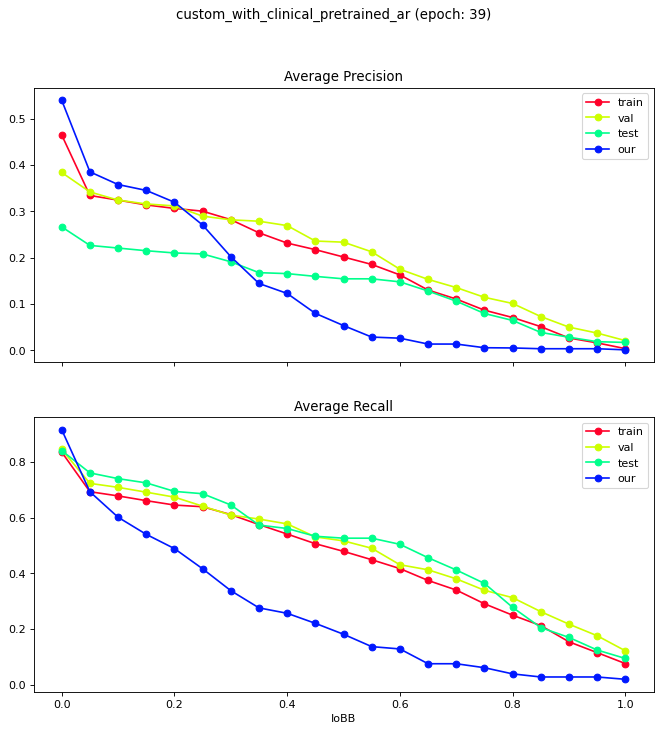

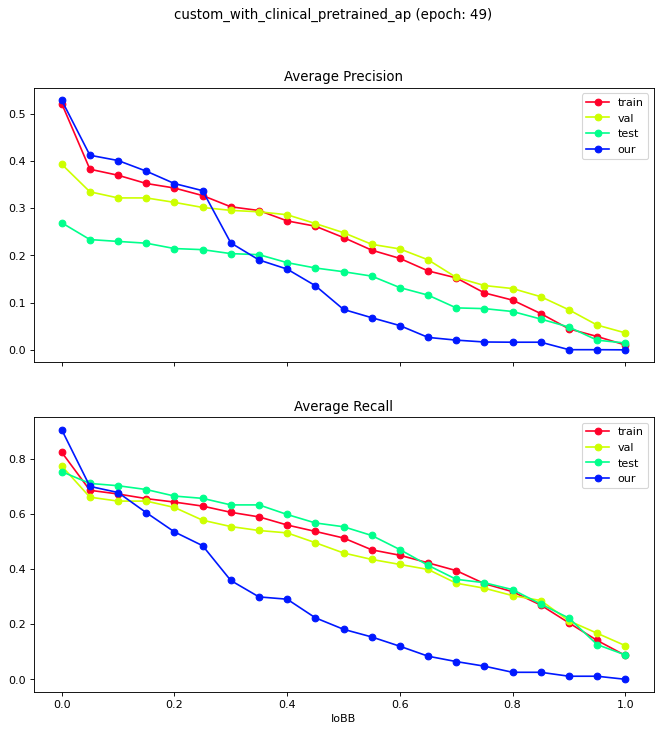

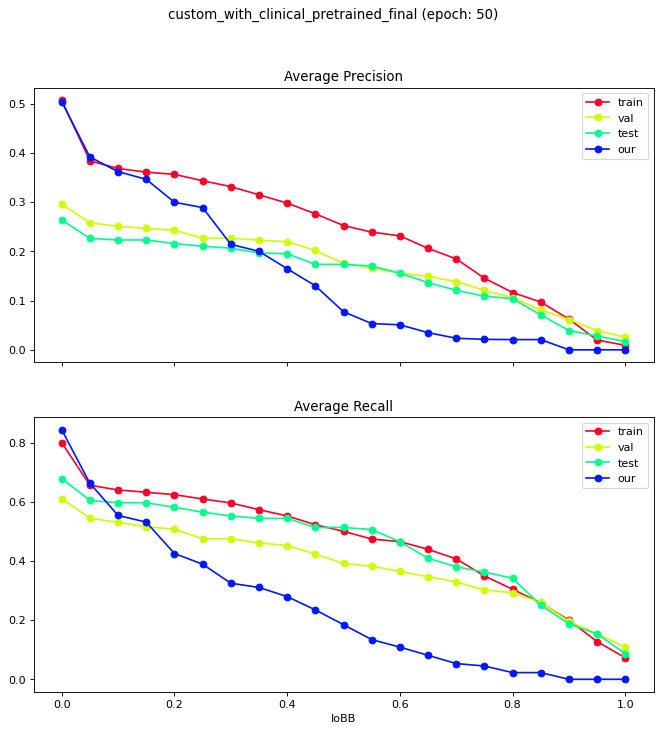

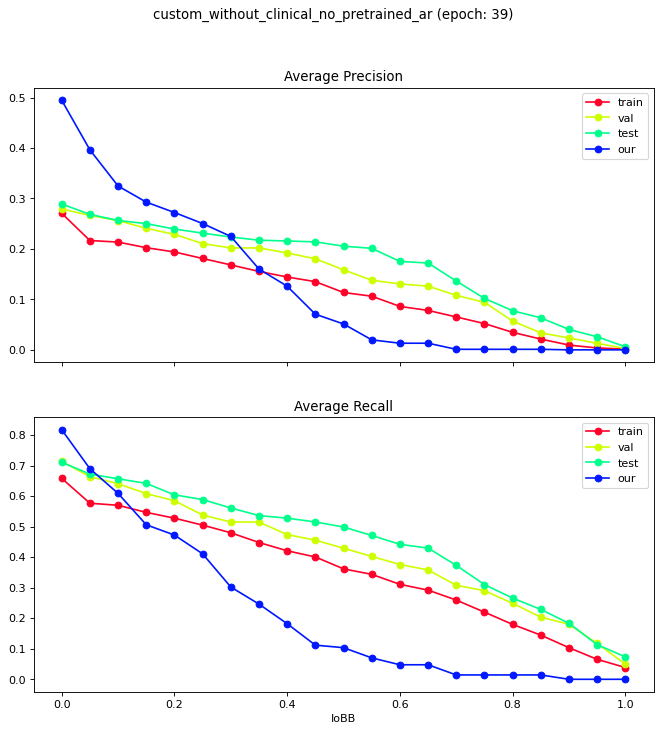

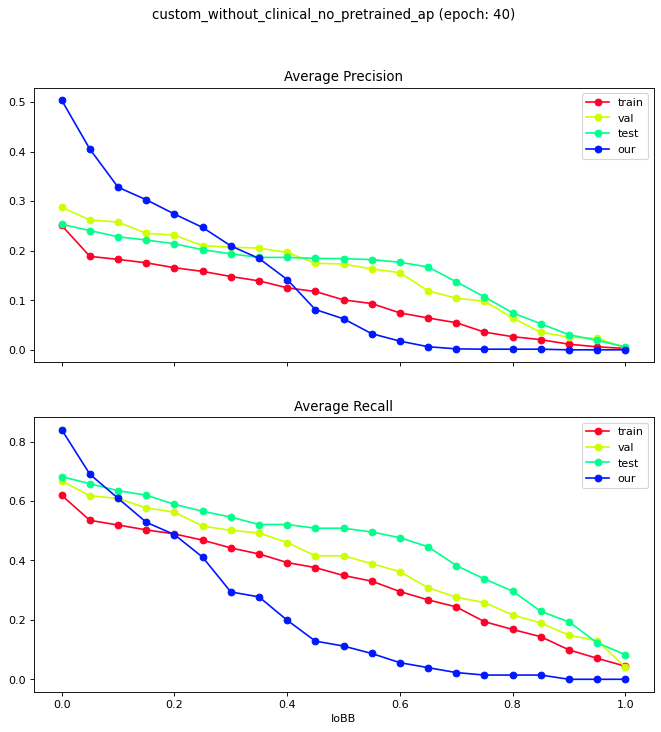

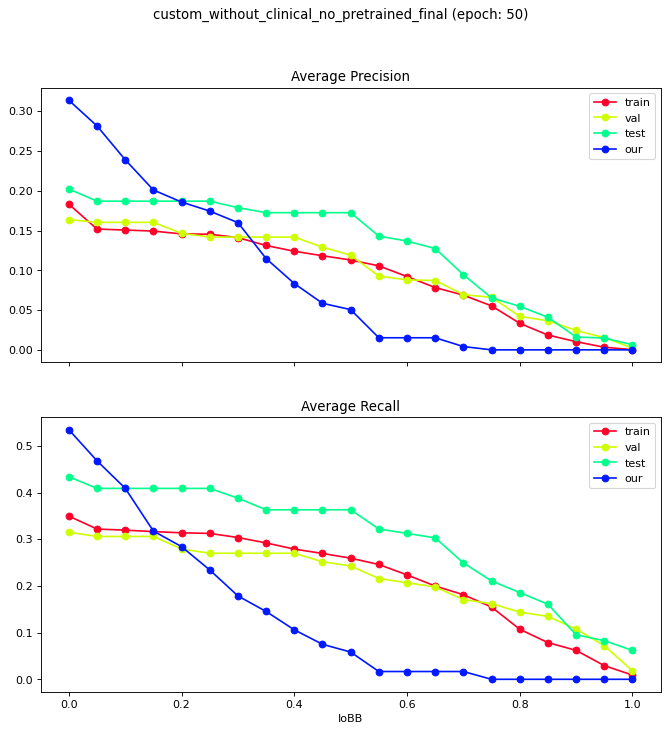

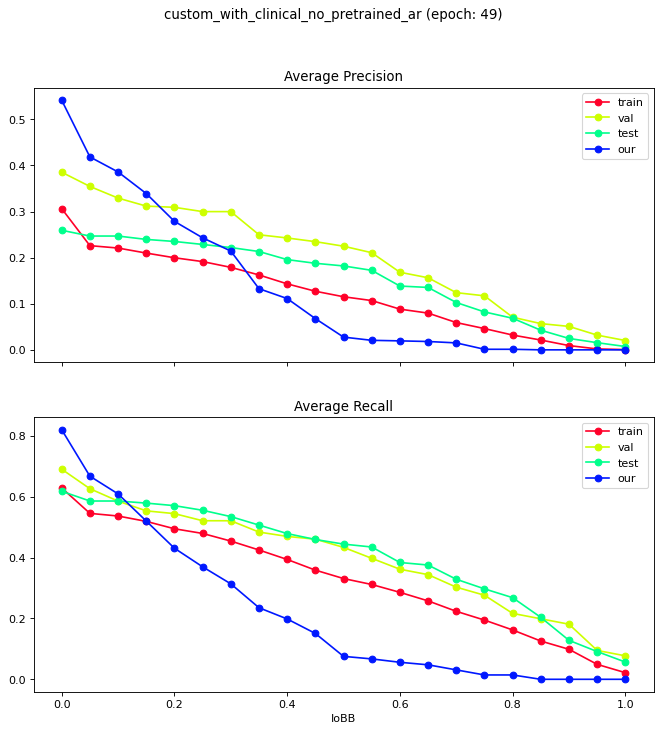

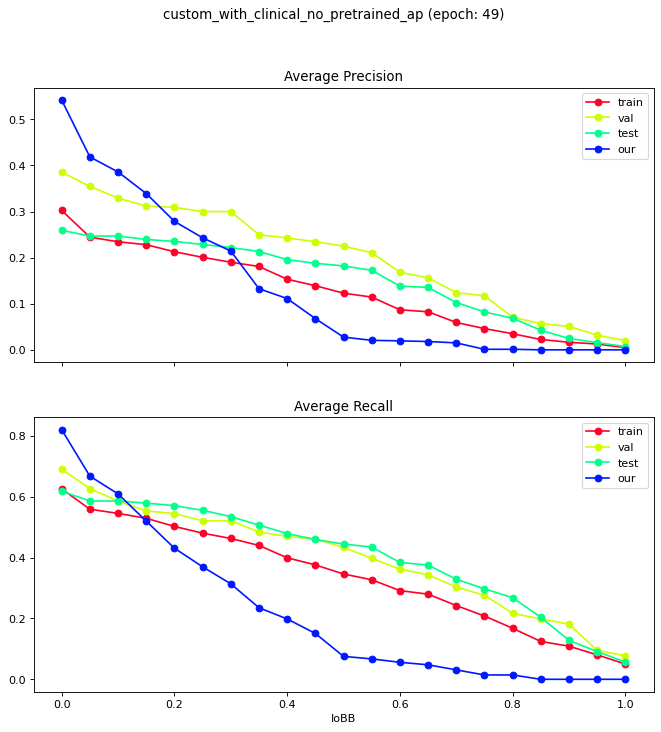

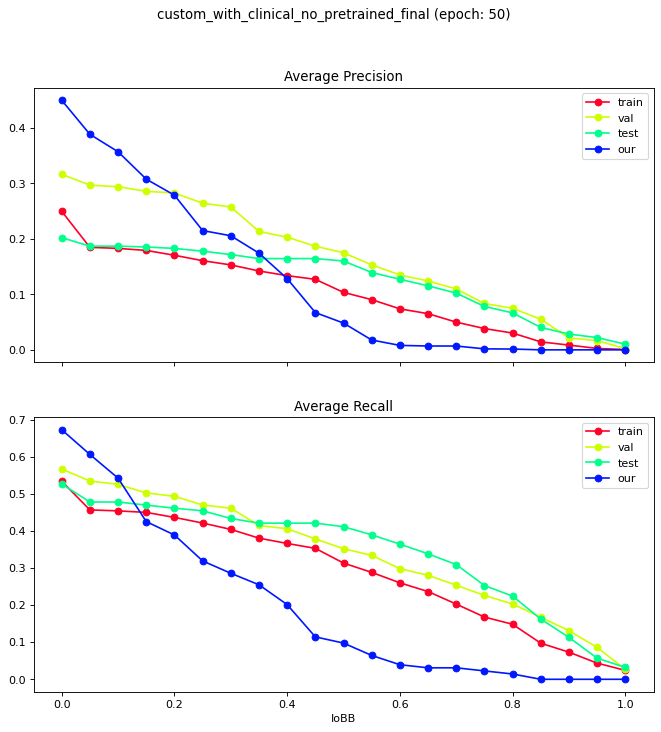

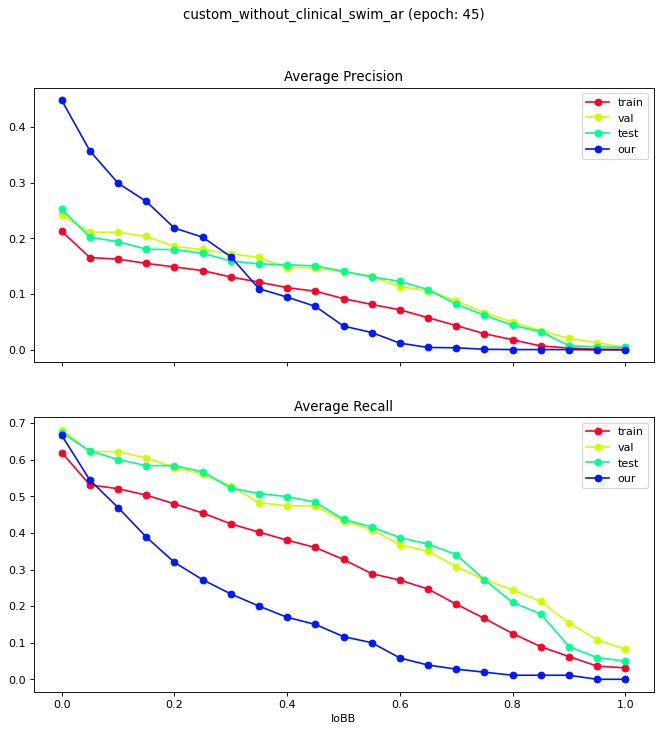

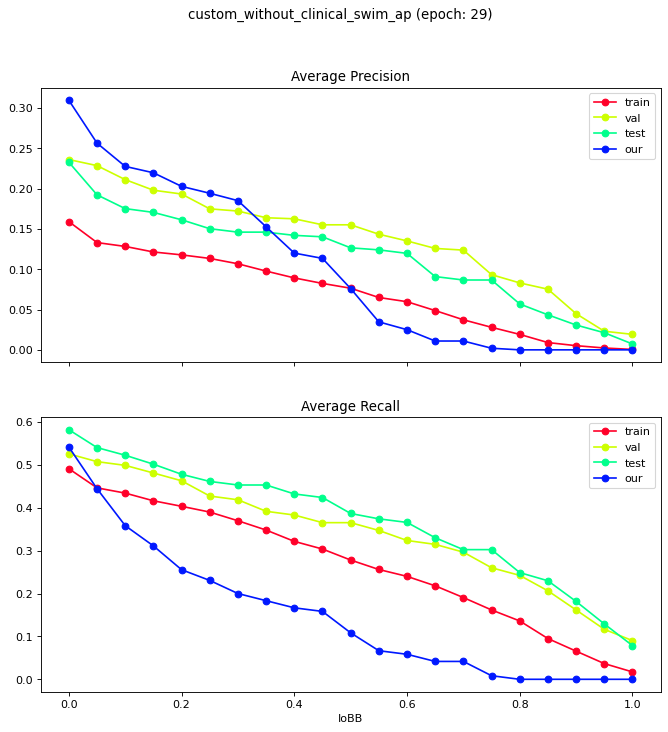

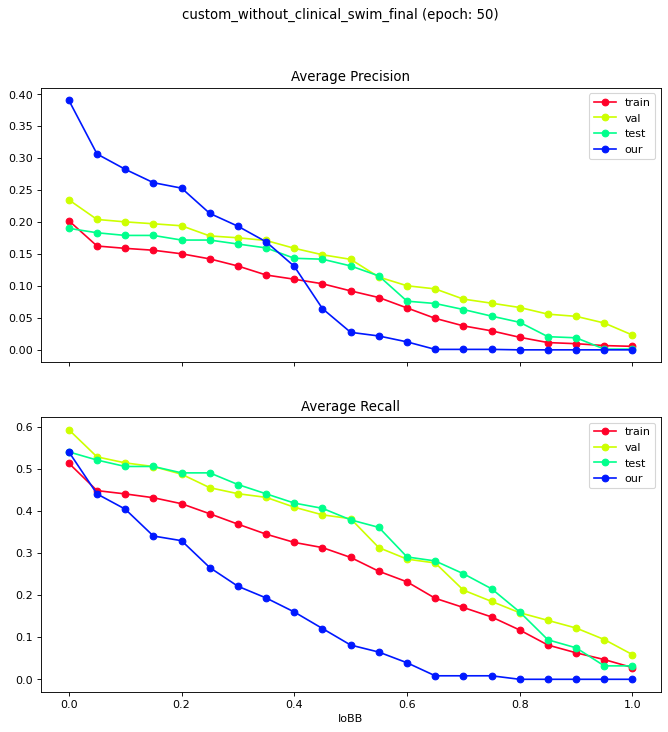

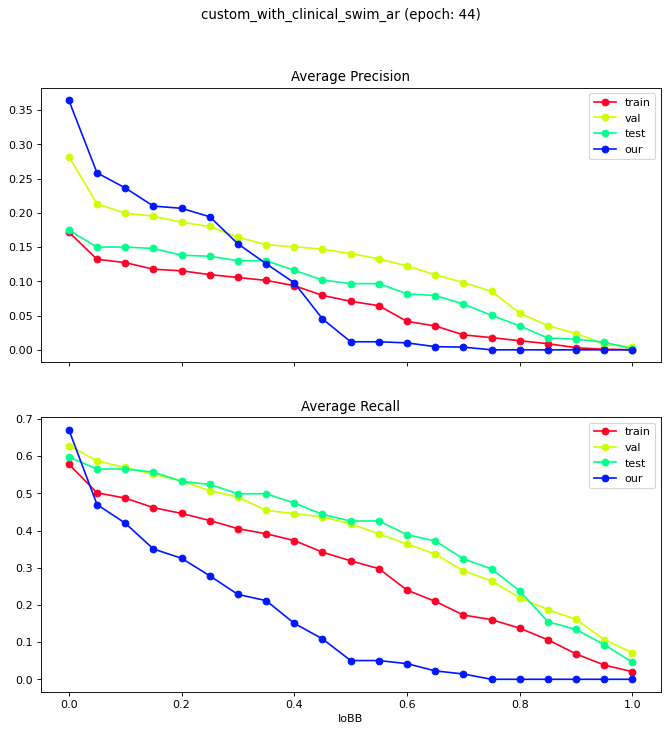

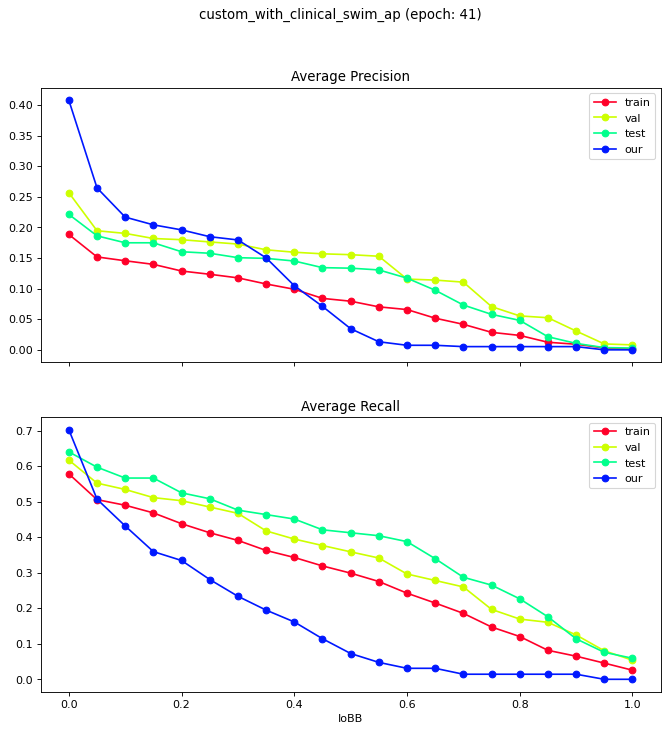

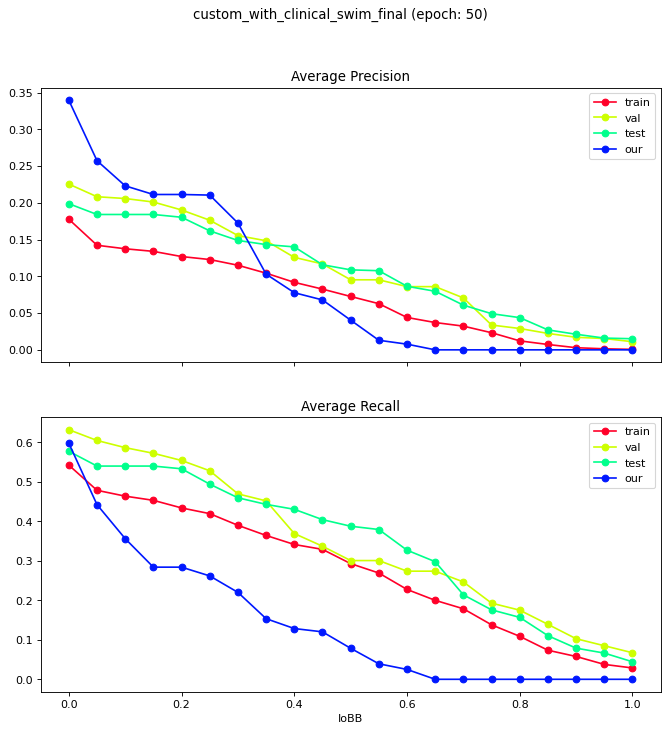

In [15]:
for select_model in TrainedModels:
    _= showModelOnDatasets(
        select_model=select_model,
        datasets=['train','val', 'test', 'our'],
        disease='all',
    )

## Comparing pretrained and no pretrained model in with no clinical data circumstance.

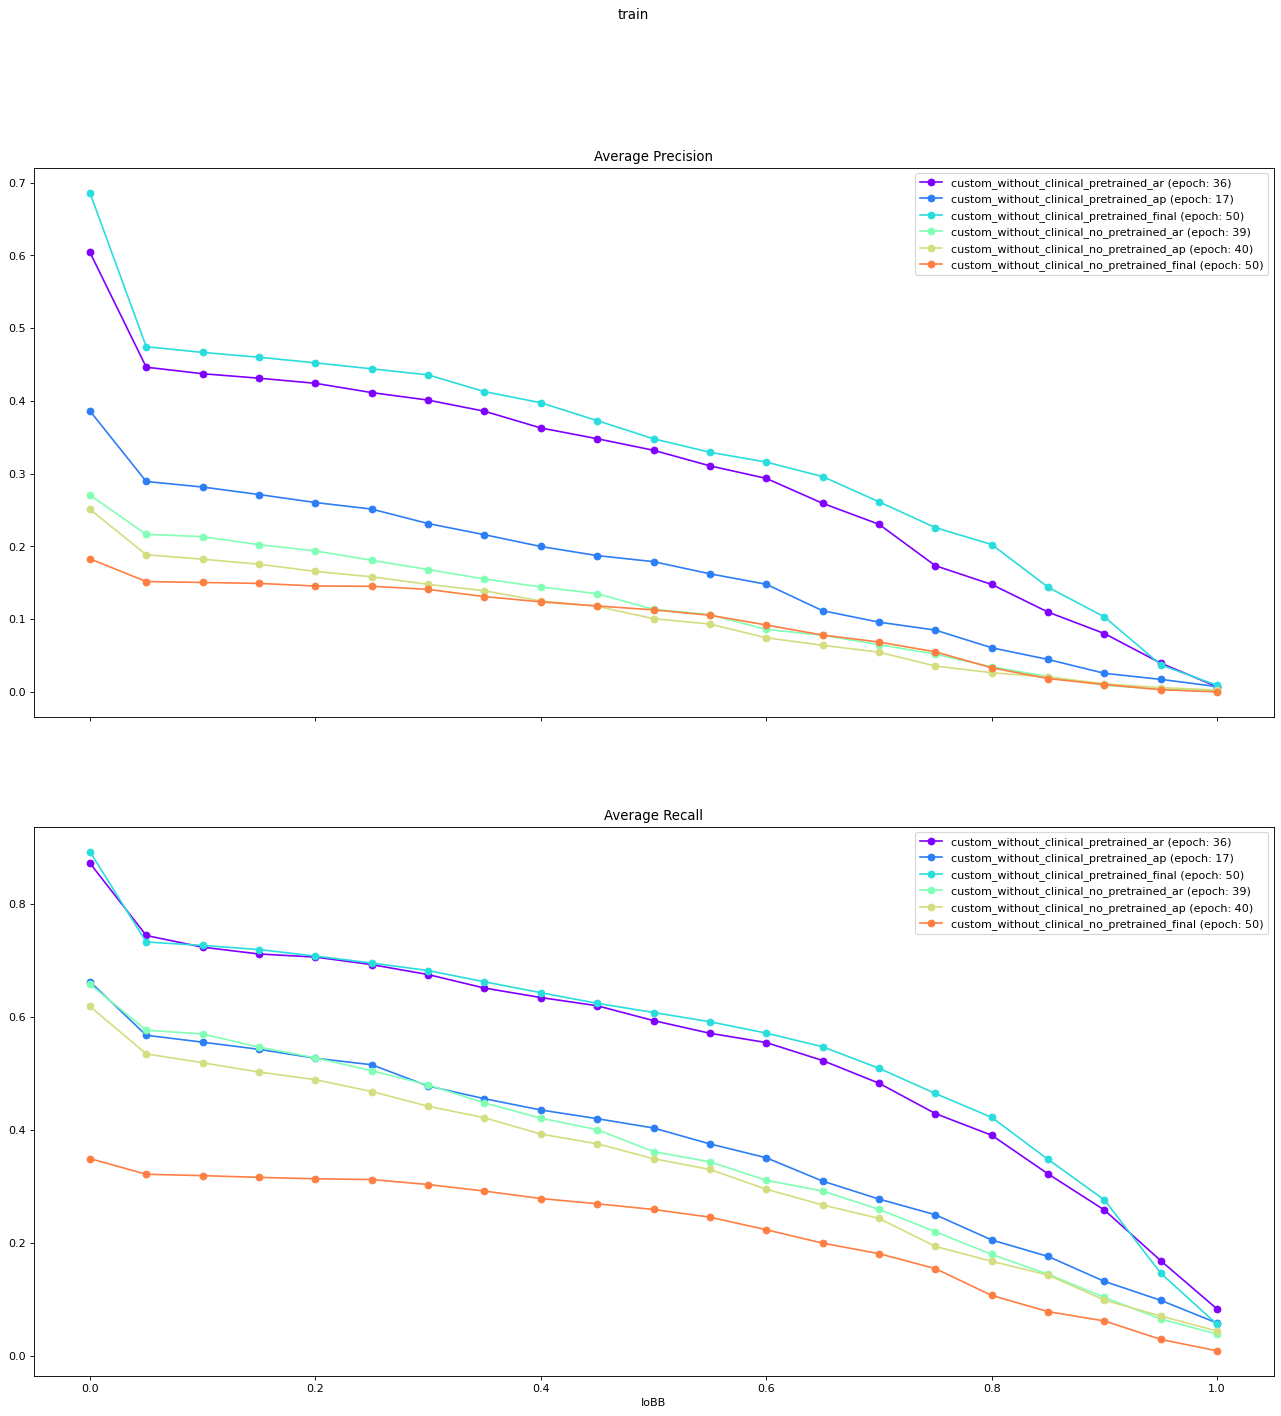

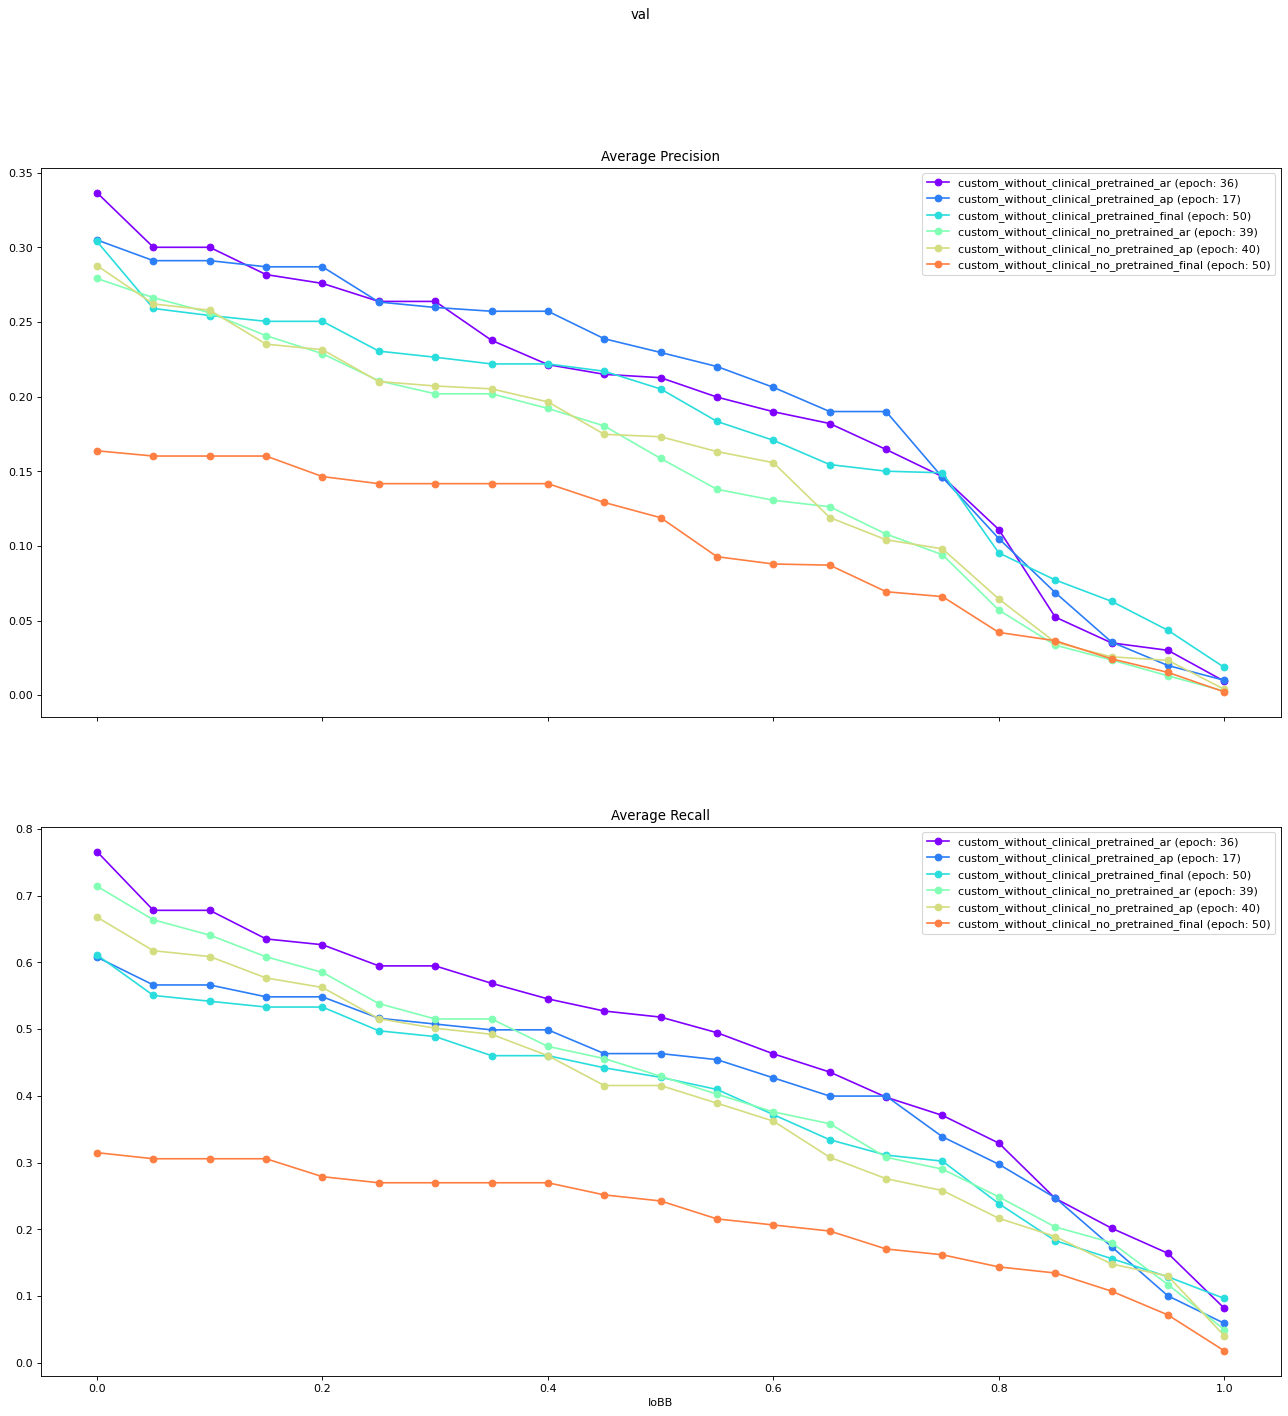

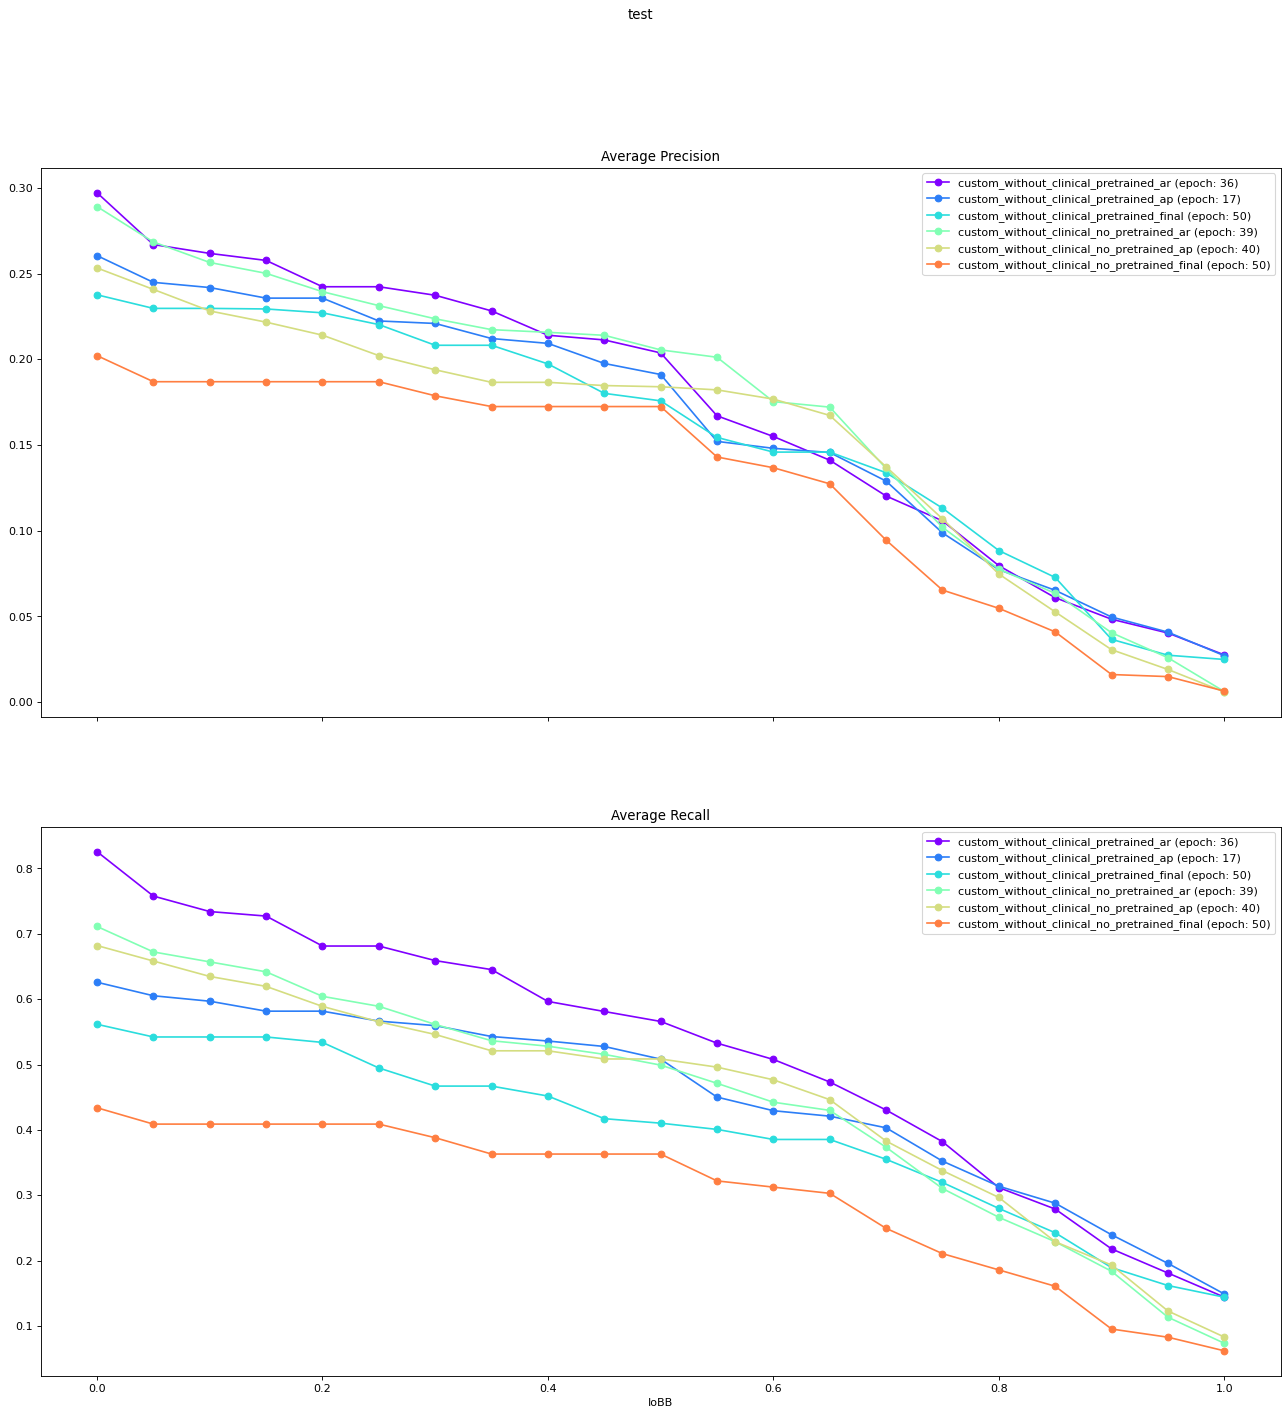

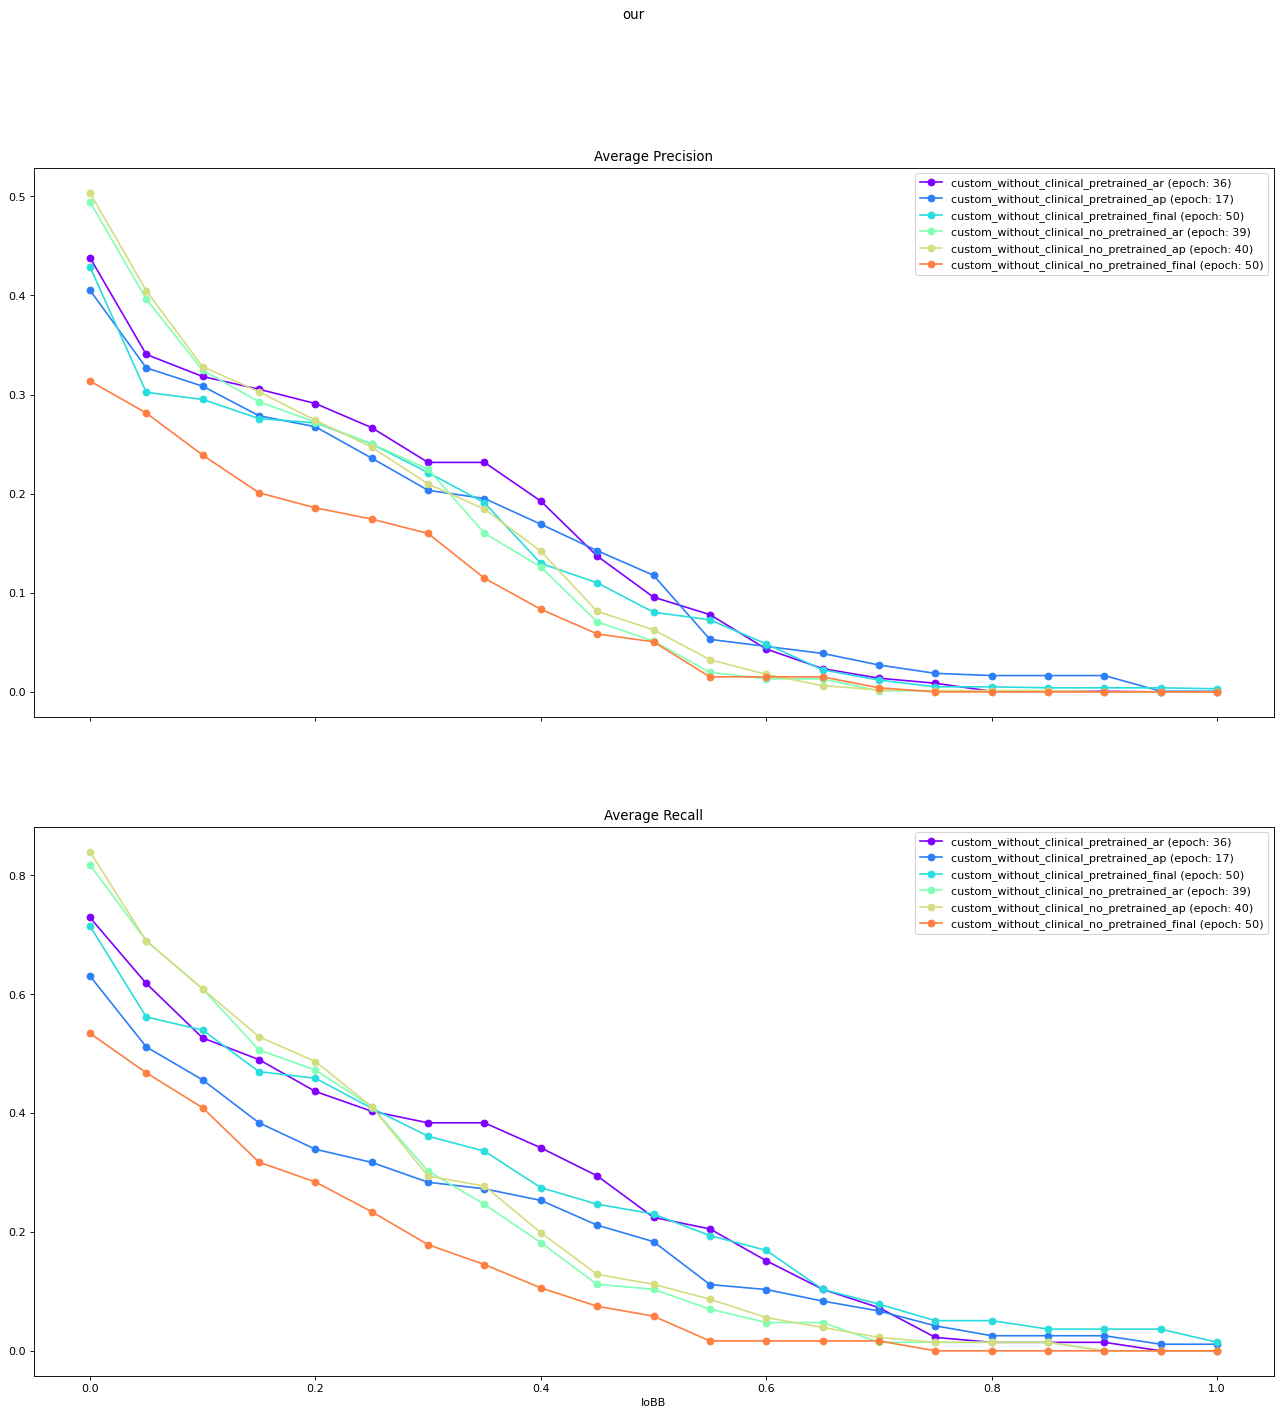

In [24]:
pretrained_and_no_pretrained_without_clinical = [
    TrainedModels.custom_without_clinical_pretrained_ar,
    TrainedModels.custom_without_clinical_pretrained_ap,
    TrainedModels.custom_without_clinical_pretrained_final,
    TrainedModels.custom_without_clinical_no_pretrained_ar,
    TrainedModels.custom_without_clinical_no_pretrained_ap,
    TrainedModels.custom_without_clinical_no_pretrained_final,
]

_ = plot_iou_result(
    pretrained_and_no_pretrained_without_clinical, "train", figsize=(20, 20)
)
_ = plot_iou_result(
    pretrained_and_no_pretrained_without_clinical, "val", figsize=(20, 20)
)
_ = plot_iou_result(
    pretrained_and_no_pretrained_without_clinical, "test", figsize=(20, 20)
)
_ = plot_iou_result(
    pretrained_and_no_pretrained_without_clinical, "our", figsize=(20, 20)
)

# pretrained model fit the dataset the best. (if train for more epoch.)
# pretrained ar ap model work best on test and validatoin dataset

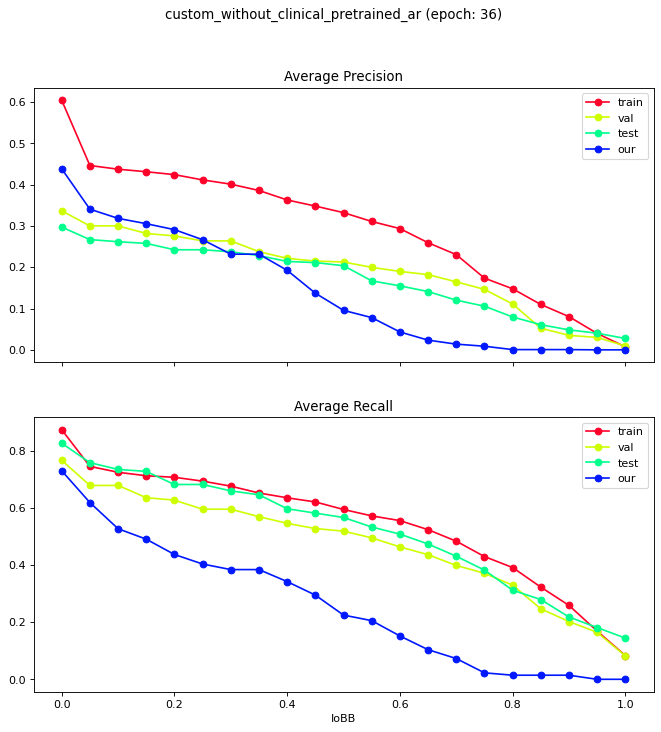

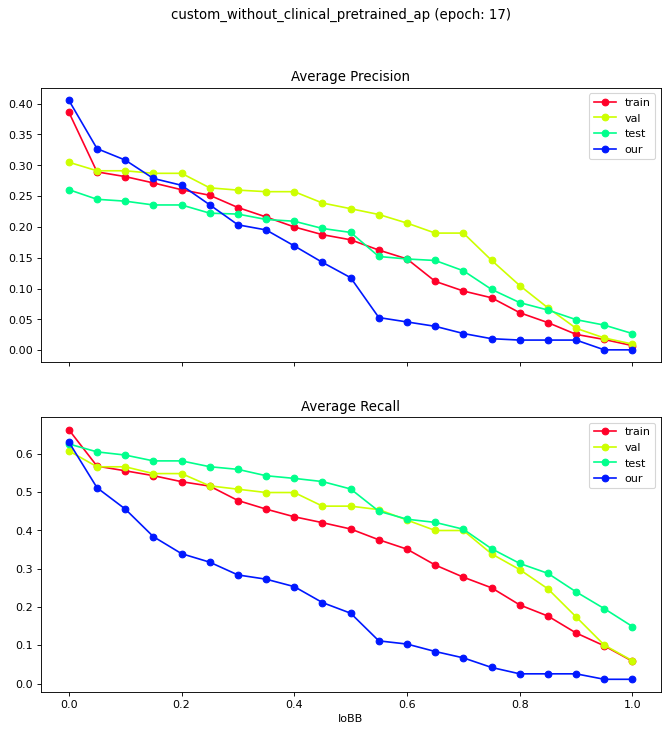

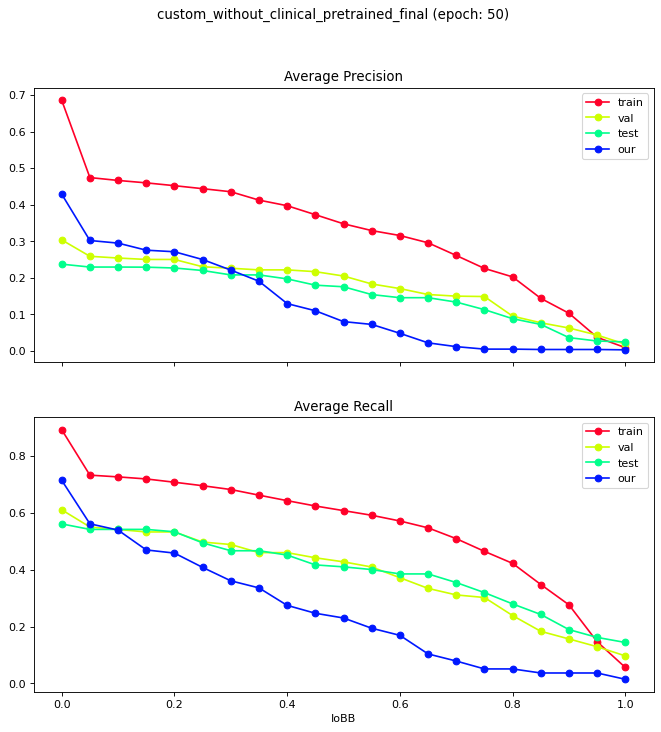

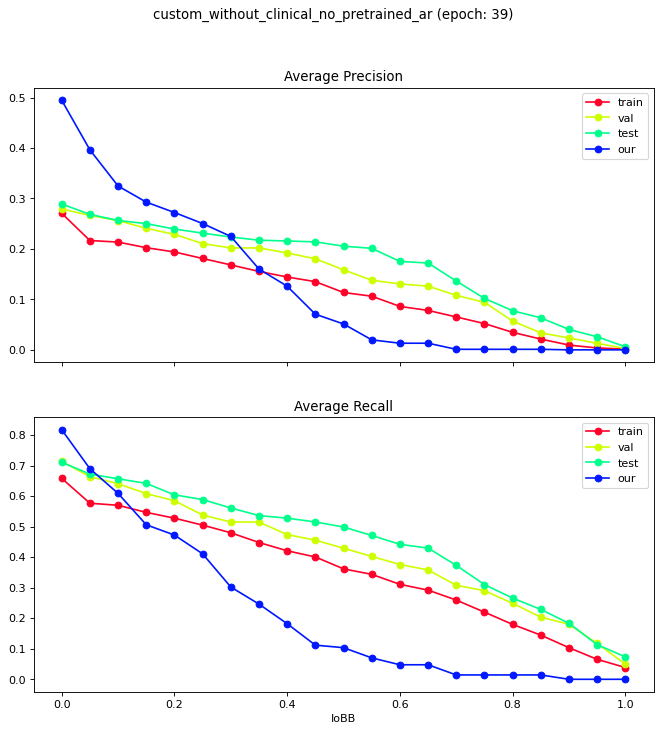

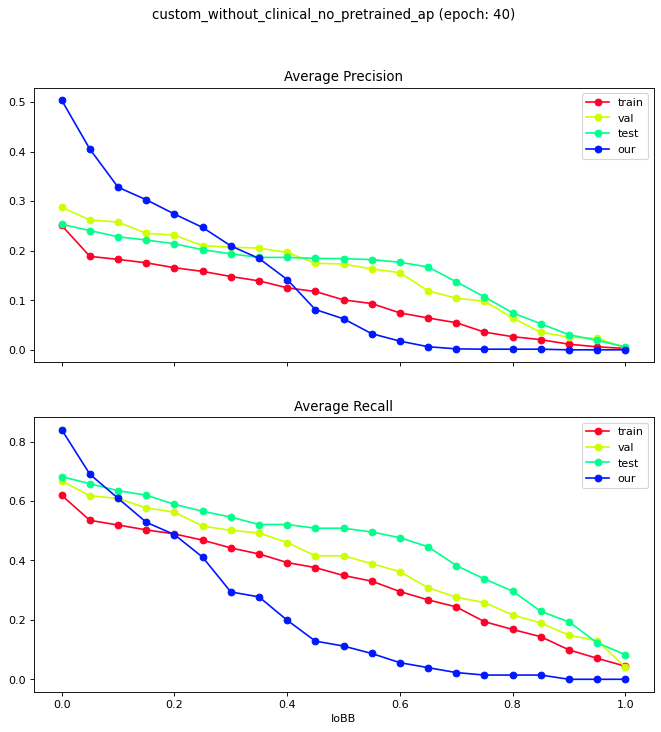

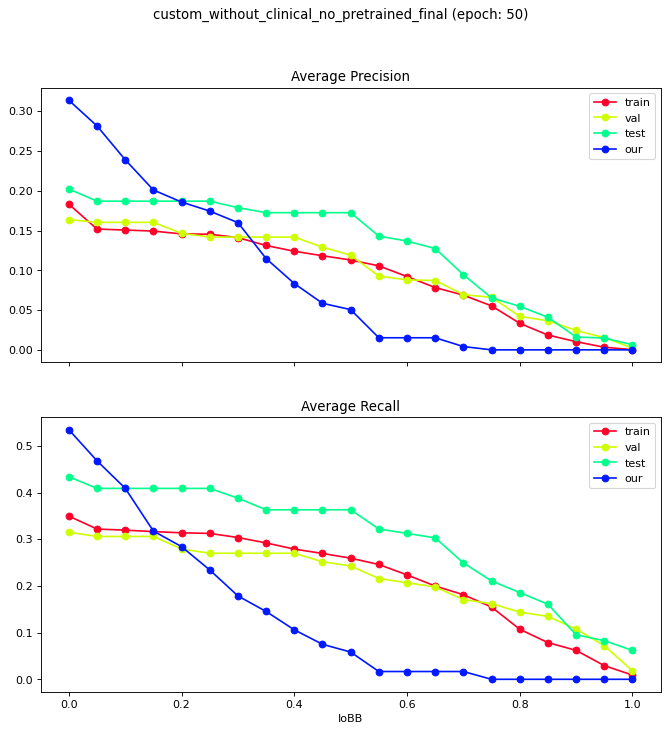

In [25]:
# Q: pretrained and unpretrained models, which one has a worse overfitting issue?

for select_model in pretrained_and_no_pretrained_without_clinical:
    _ = showModelOnDatasets(
        select_model=select_model,
        datasets=["train", "val", "test", "our"],
        disease="all",
    )

# Found:
# the unpretrained model has less overfitting; however, the it may means that the model just need more epochs to converge.

# **Q:** Comparing Swin and ResNet50, which backbone is better when we just train for 50 epoch.

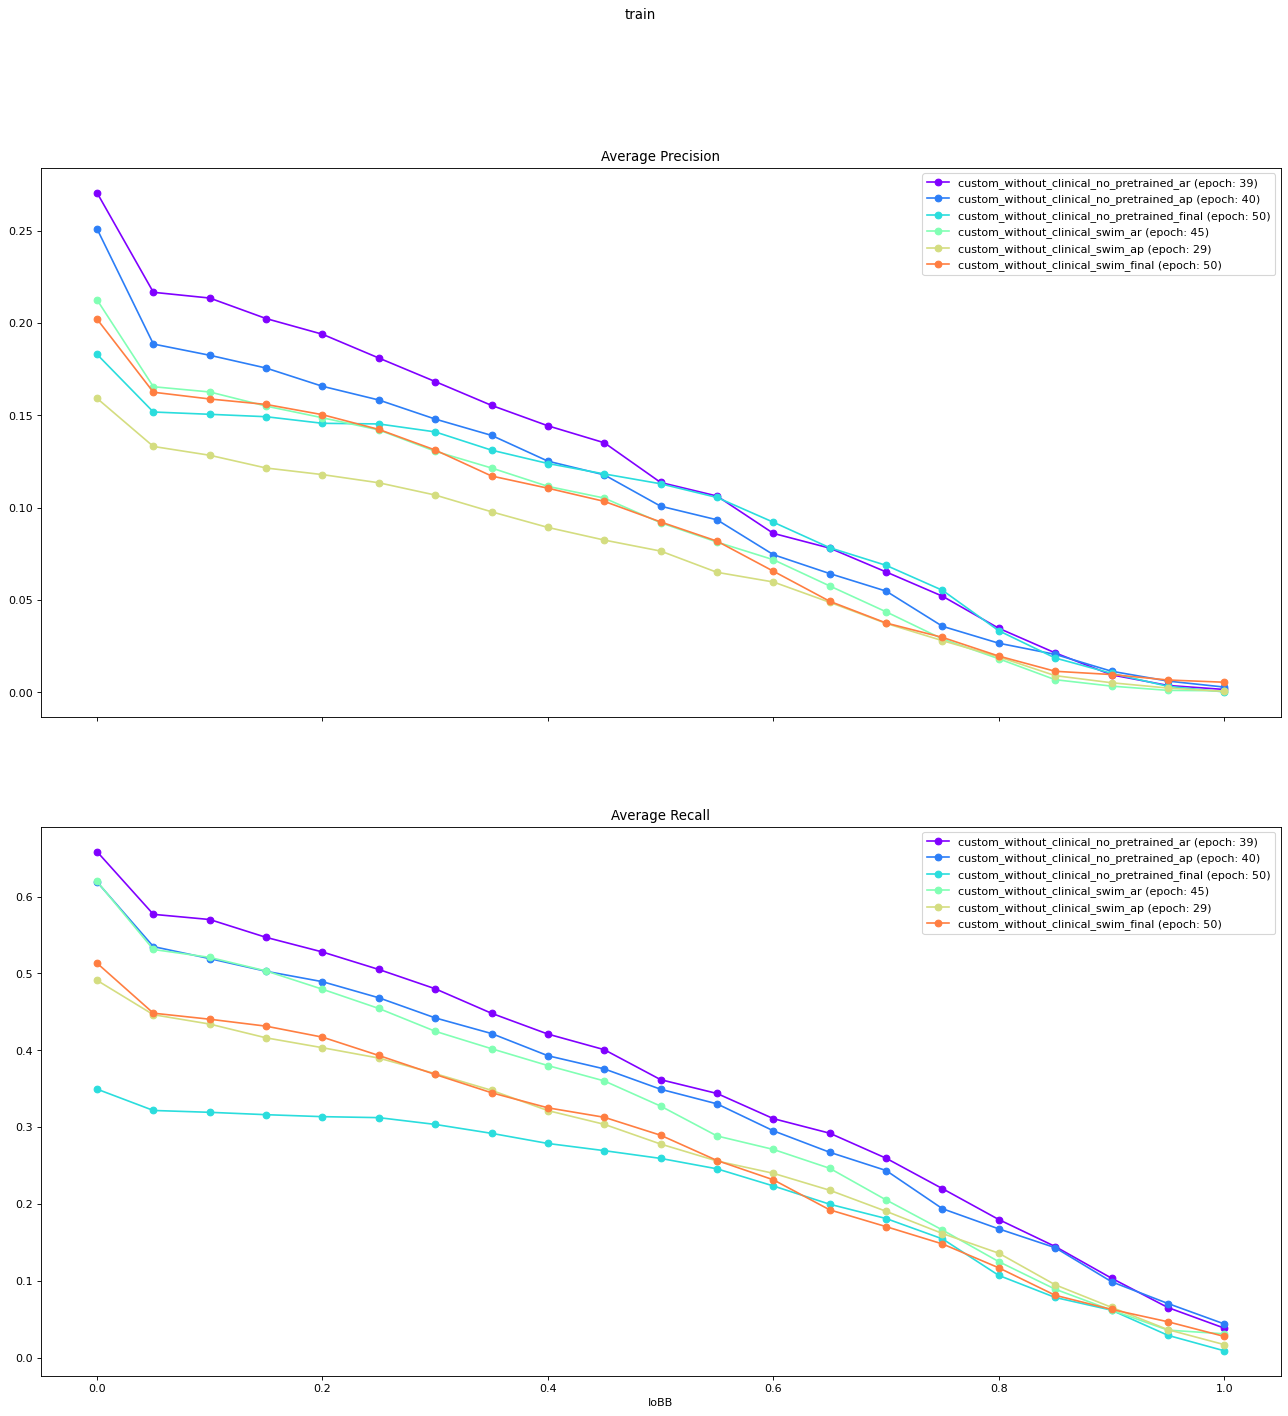

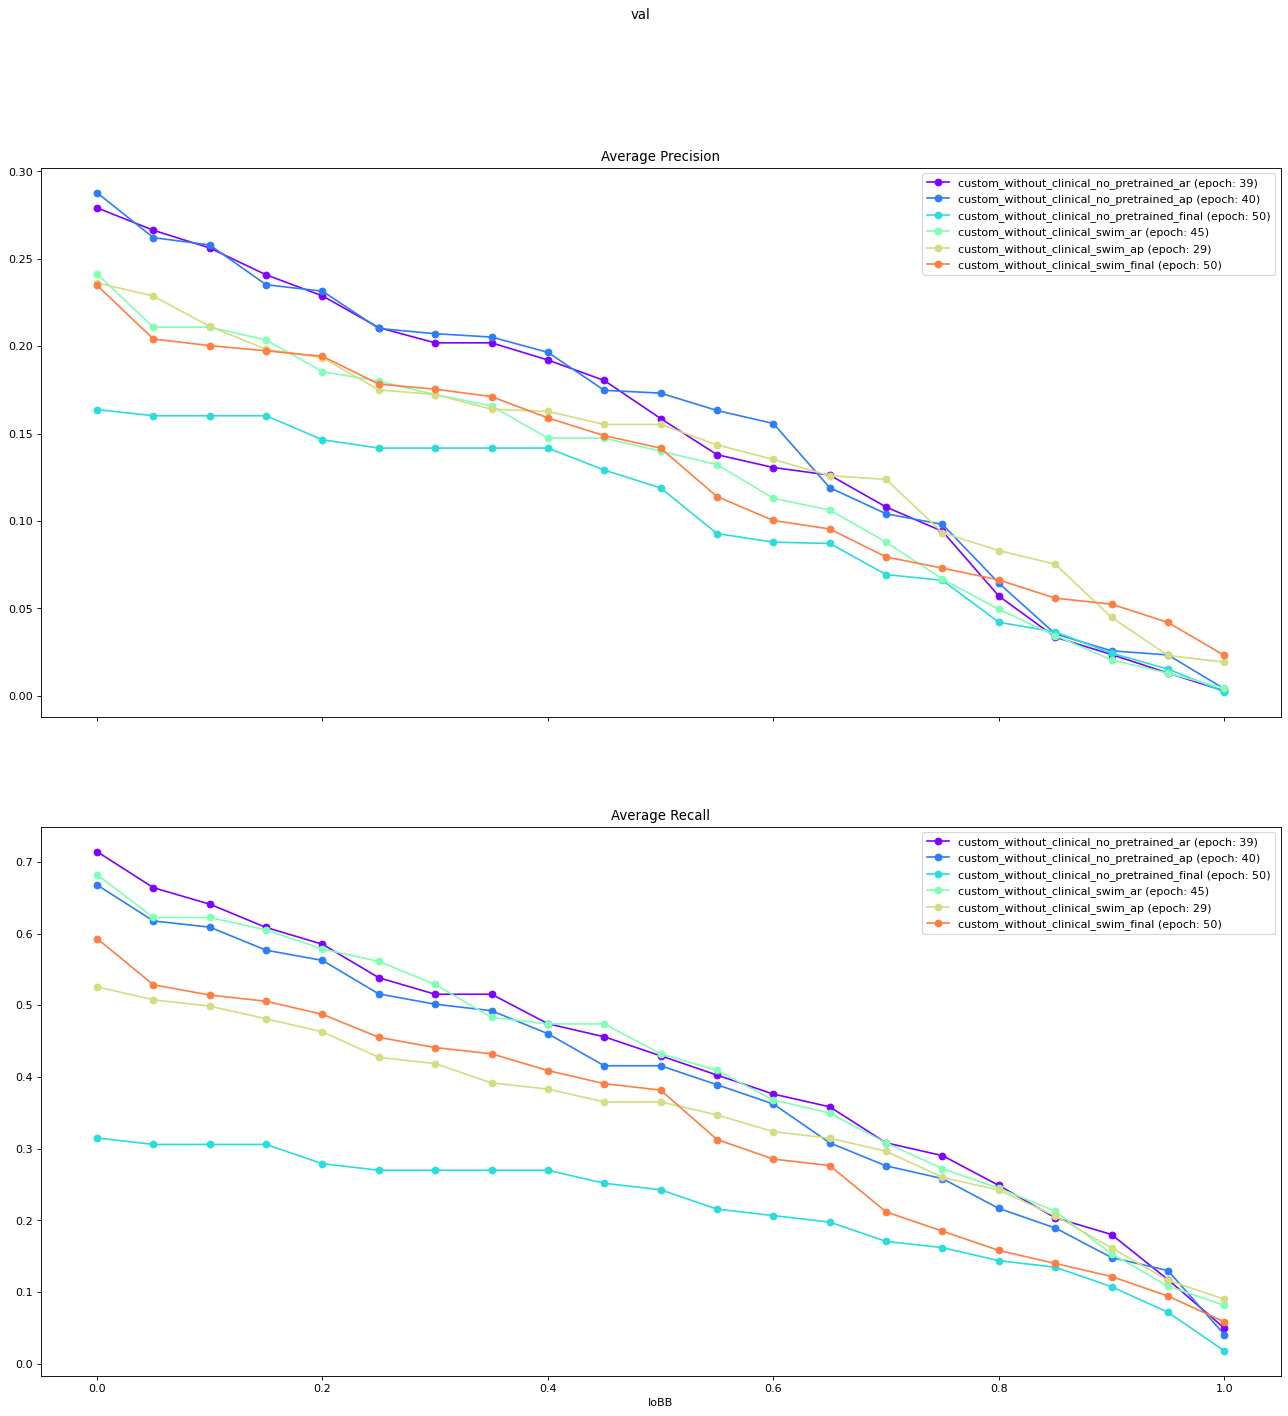

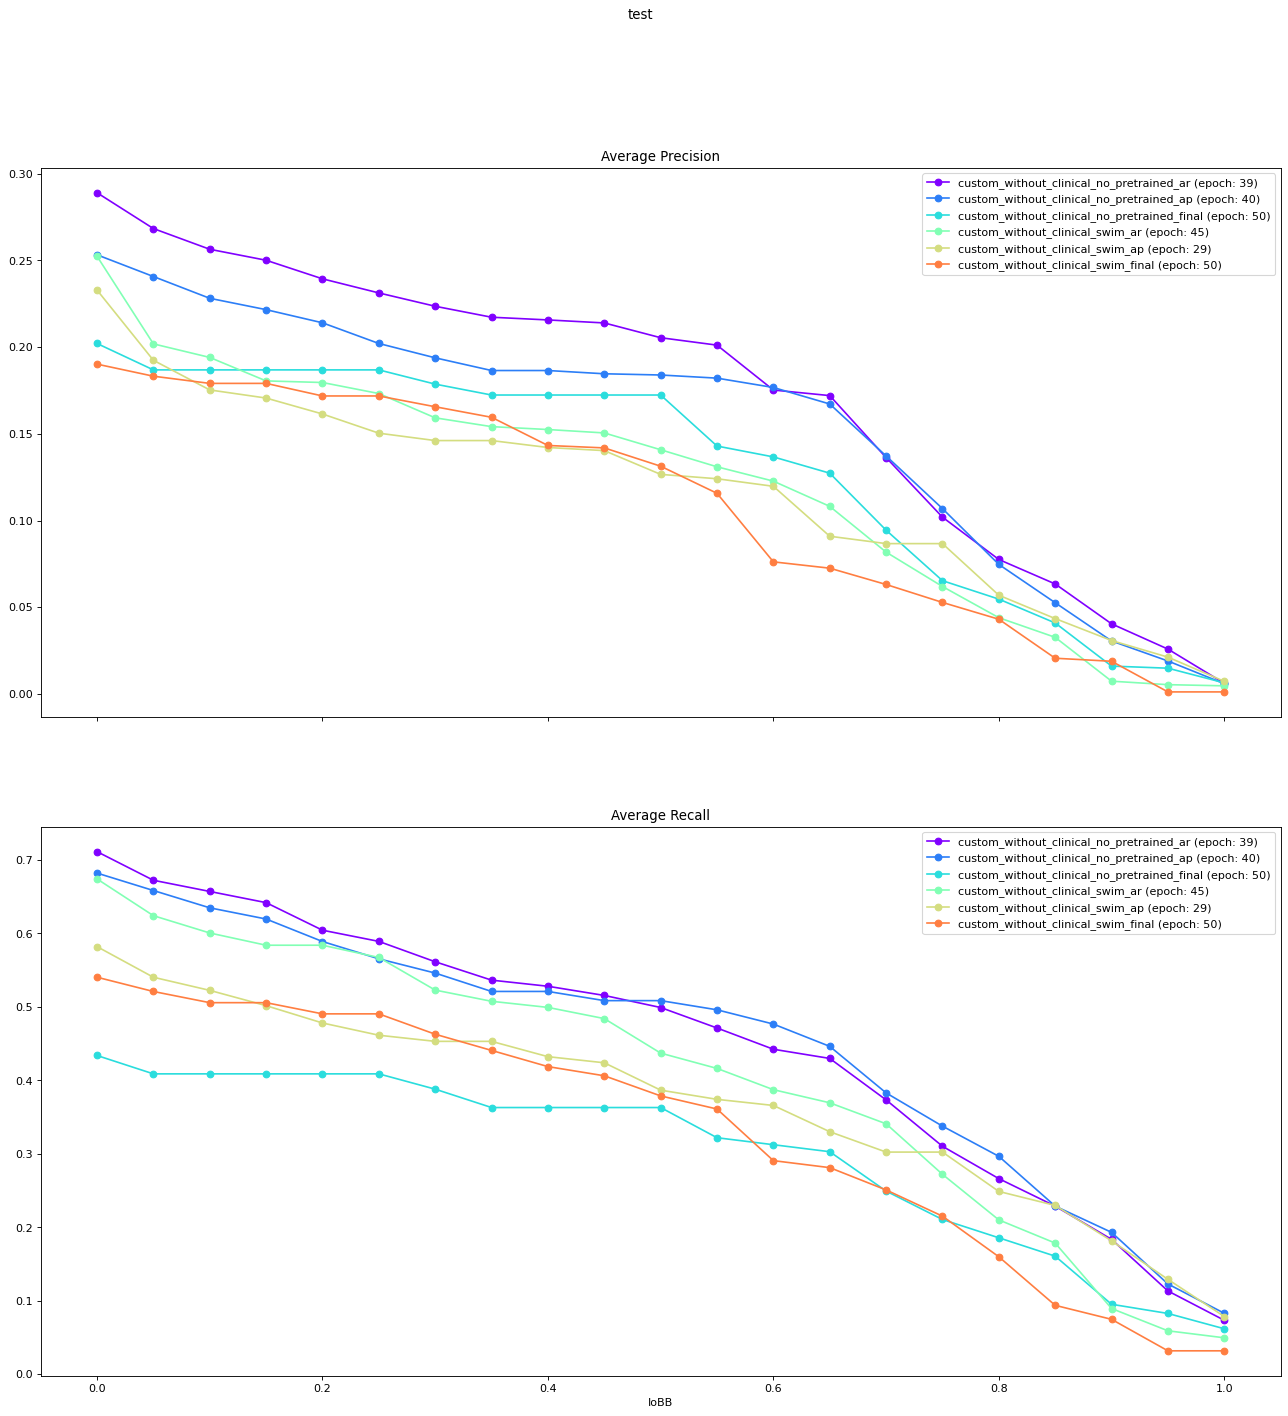

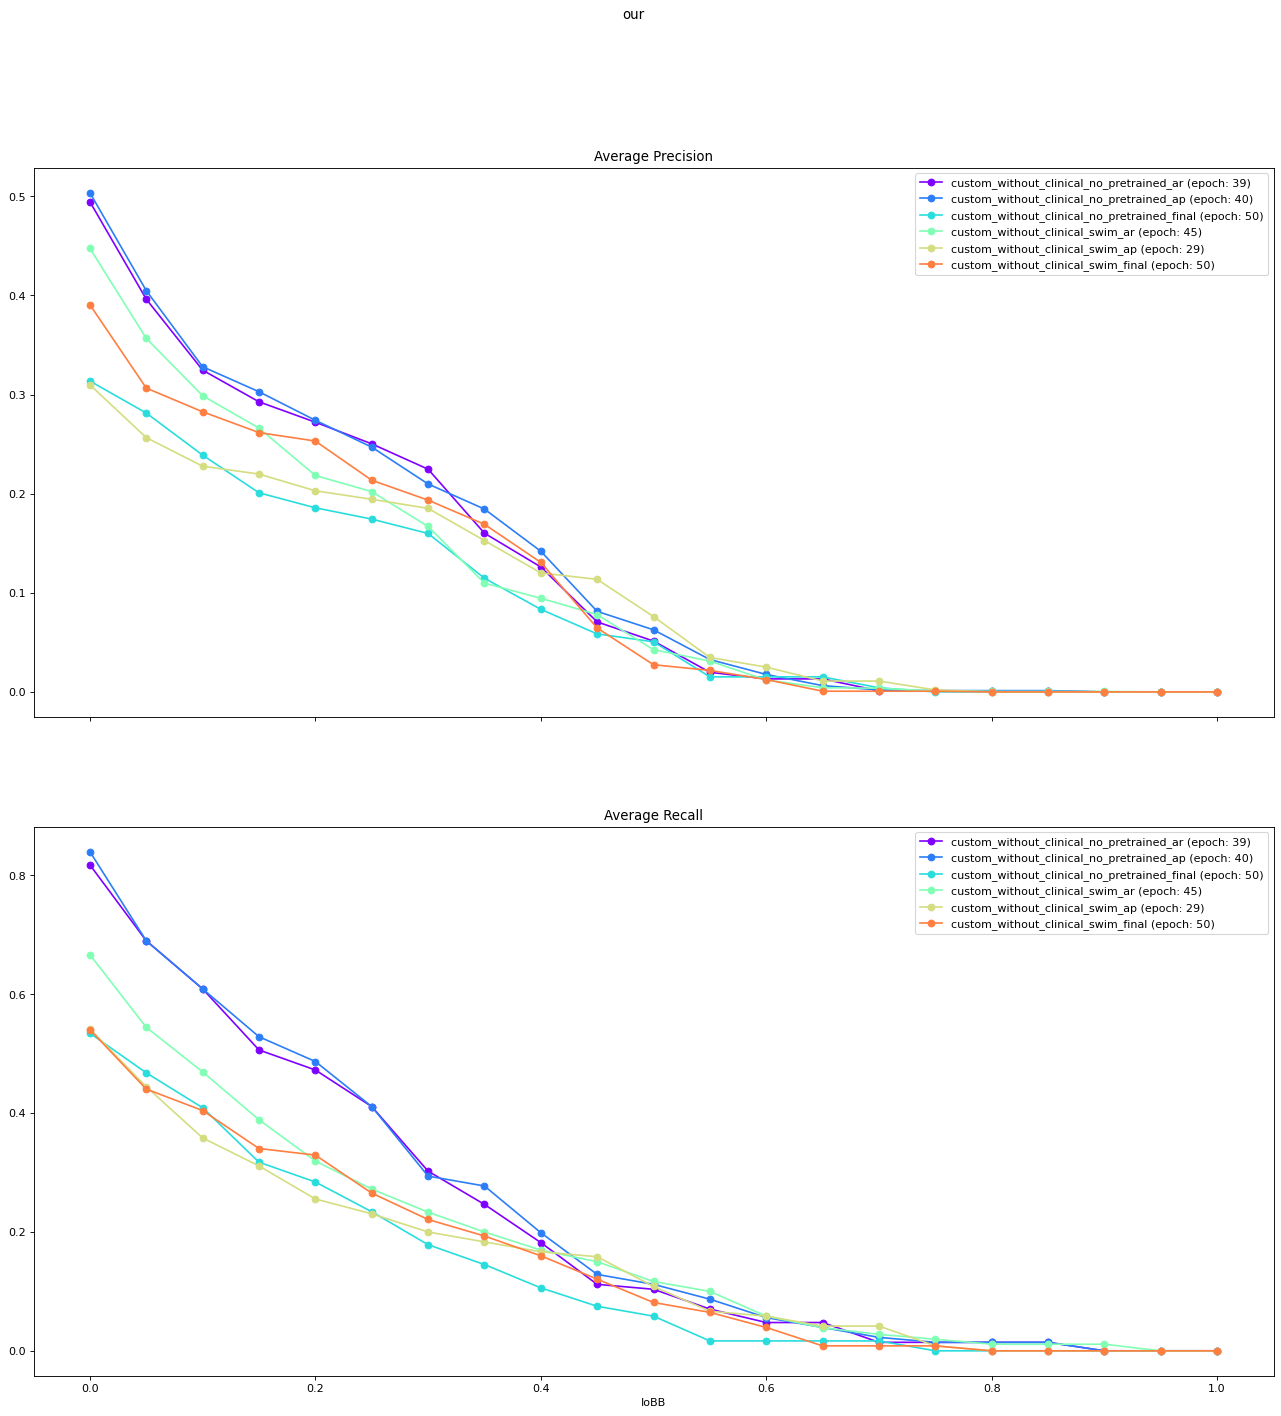

In [28]:
swin_and_resnet_models_clinical = [
    TrainedModels.custom_without_clinical_no_pretrained_ar,
    TrainedModels.custom_without_clinical_no_pretrained_ap,
    TrainedModels.custom_without_clinical_no_pretrained_final,

    TrainedModels.custom_without_clinical_swim_ar,
    TrainedModels.custom_without_clinical_swim_ap,
    TrainedModels.custom_without_clinical_swim_final,
]

_ = plot_iou_result(
    swin_and_resnet_models_clinical, "train", figsize=(20, 20)
)
_ = plot_iou_result(
    swin_and_resnet_models_clinical, "val", figsize=(20, 20)
)
_ = plot_iou_result(
    swin_and_resnet_models_clinical, "test", figsize=(20, 20)
)
_ = plot_iou_result(
    swin_and_resnet_models_clinical, "our", figsize=(20, 20)
)

# Found:
# Swin converge latter than ResNet50, so the ResNet50 perform better than 

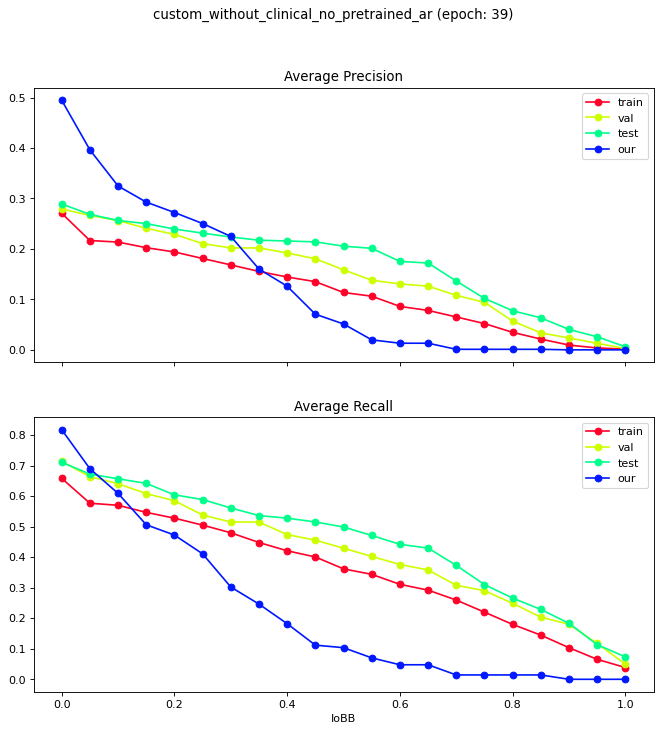

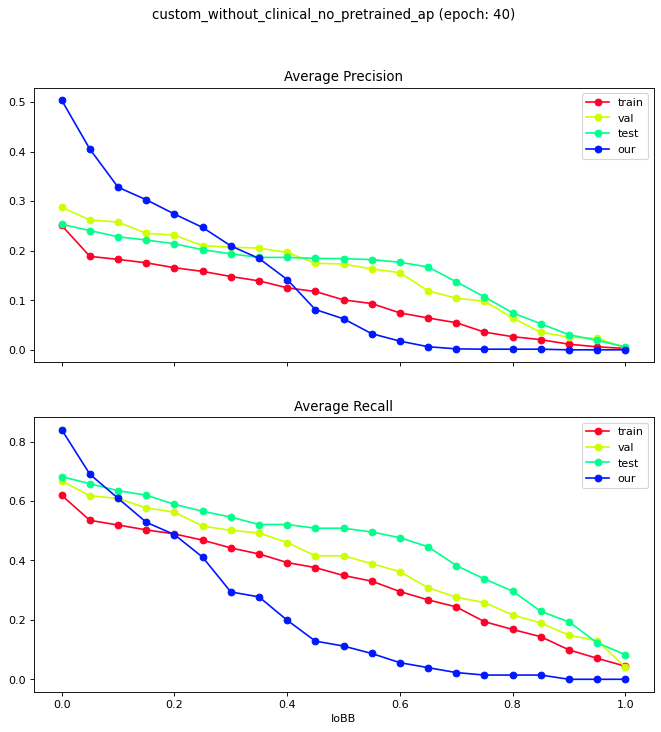

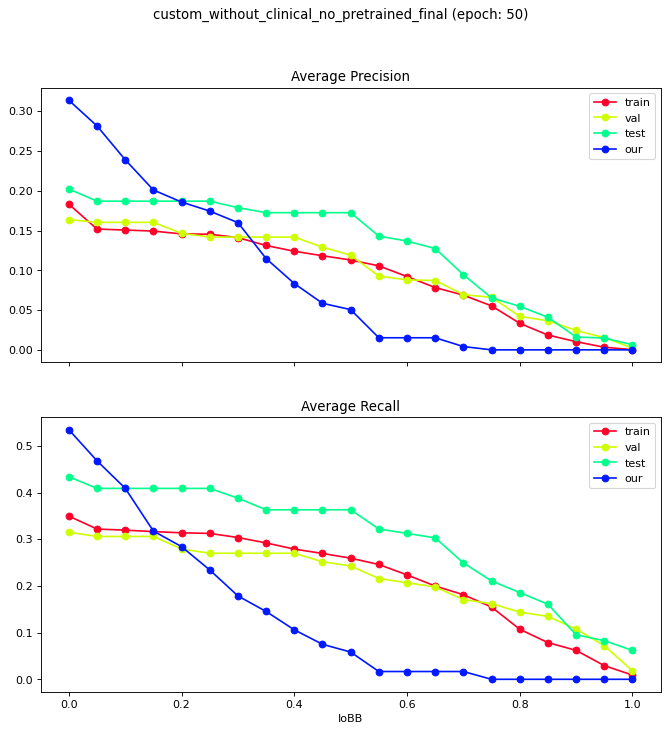

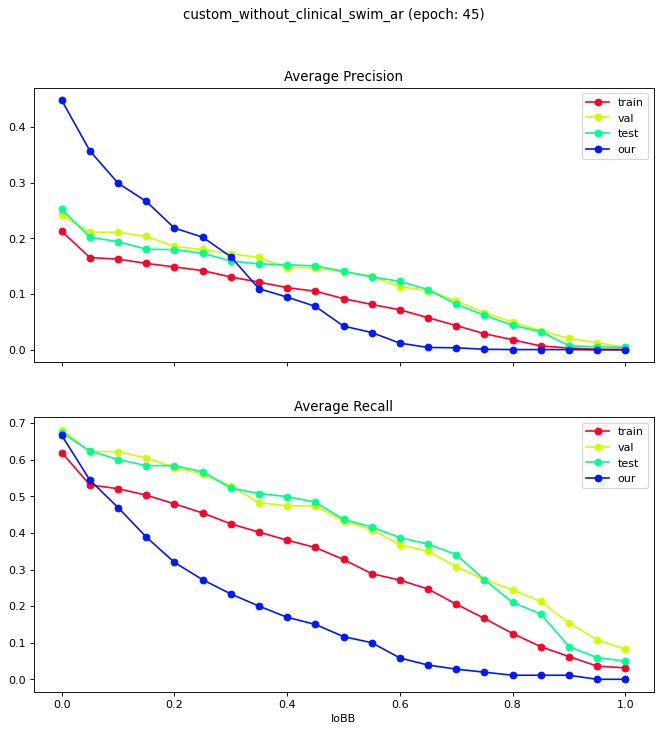

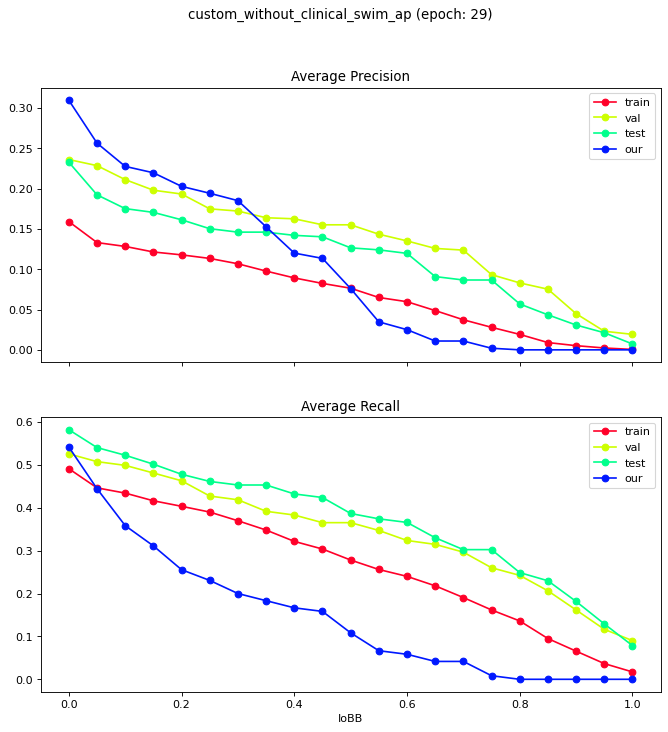

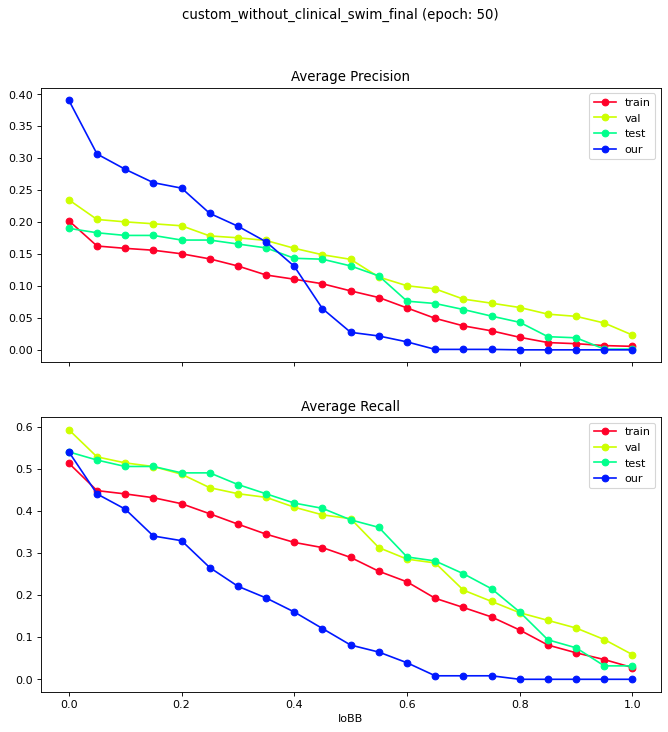

In [29]:
for select_model in swin_and_resnet_models_clinical:
    _ = showModelOnDatasets(
        select_model=select_model,
        datasets=["train", "val", "test", "our"],
        disease="all",
    )

# **Q:** Compare with clinical and without clinical in pretrained model.

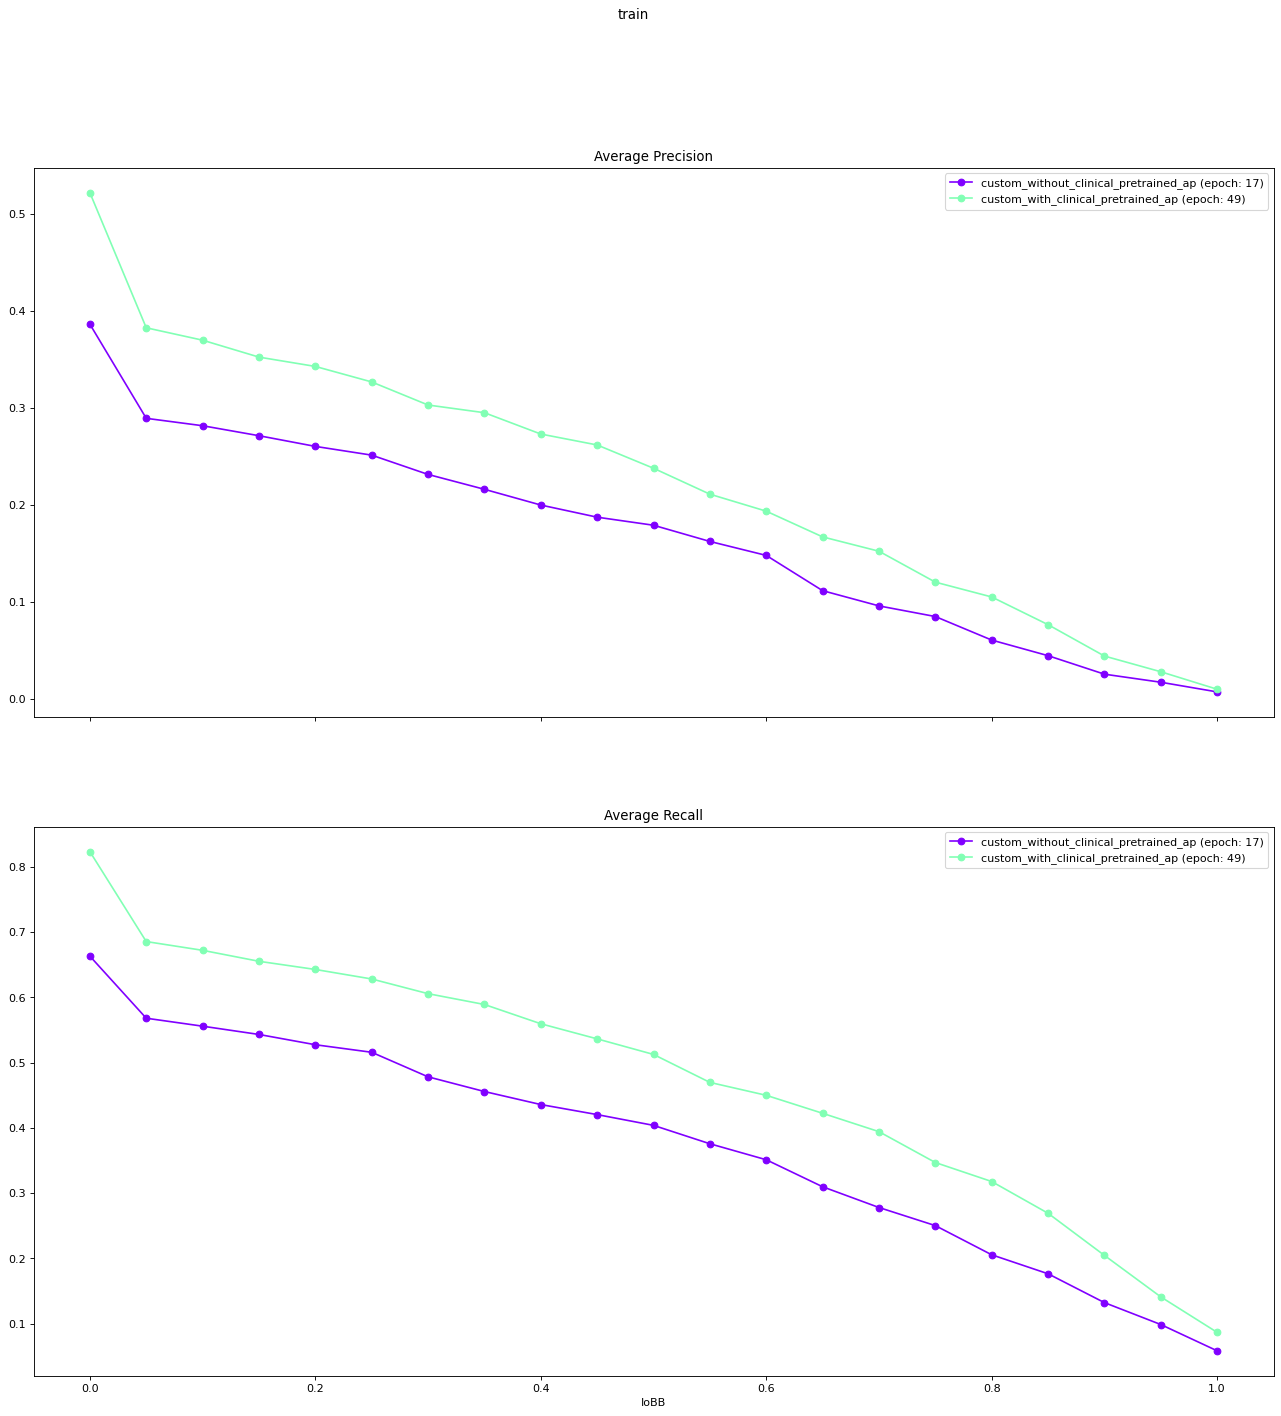

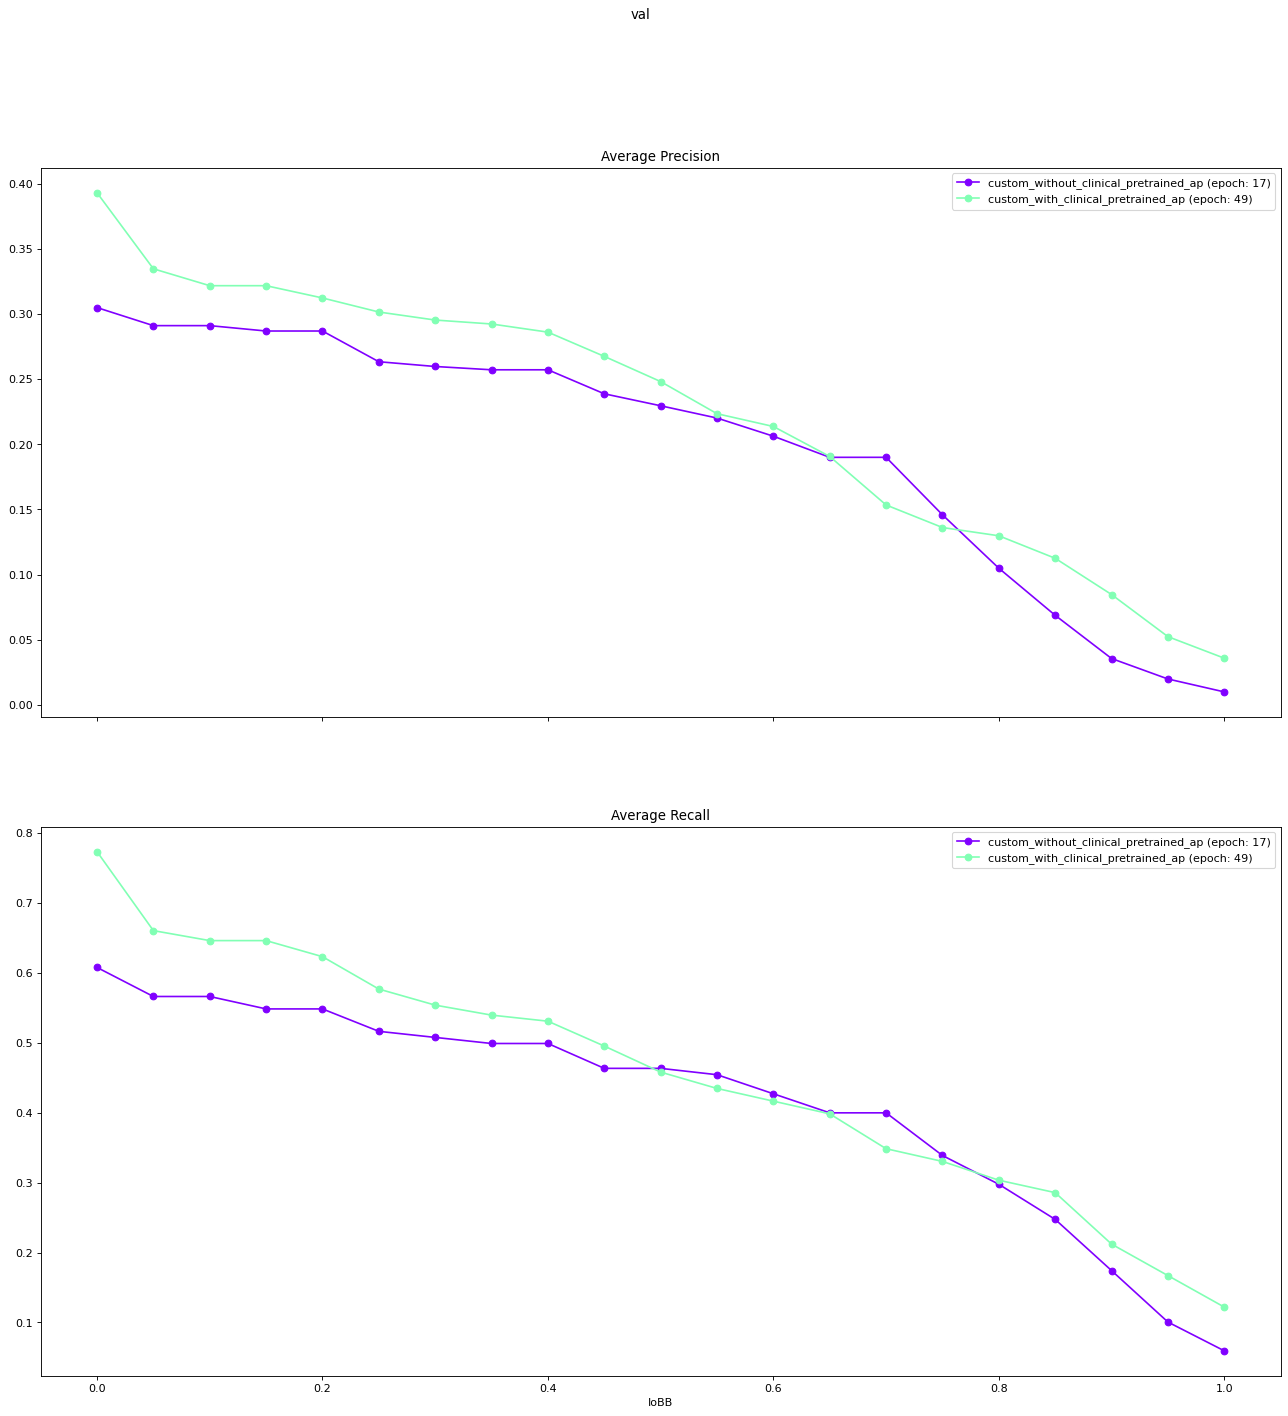

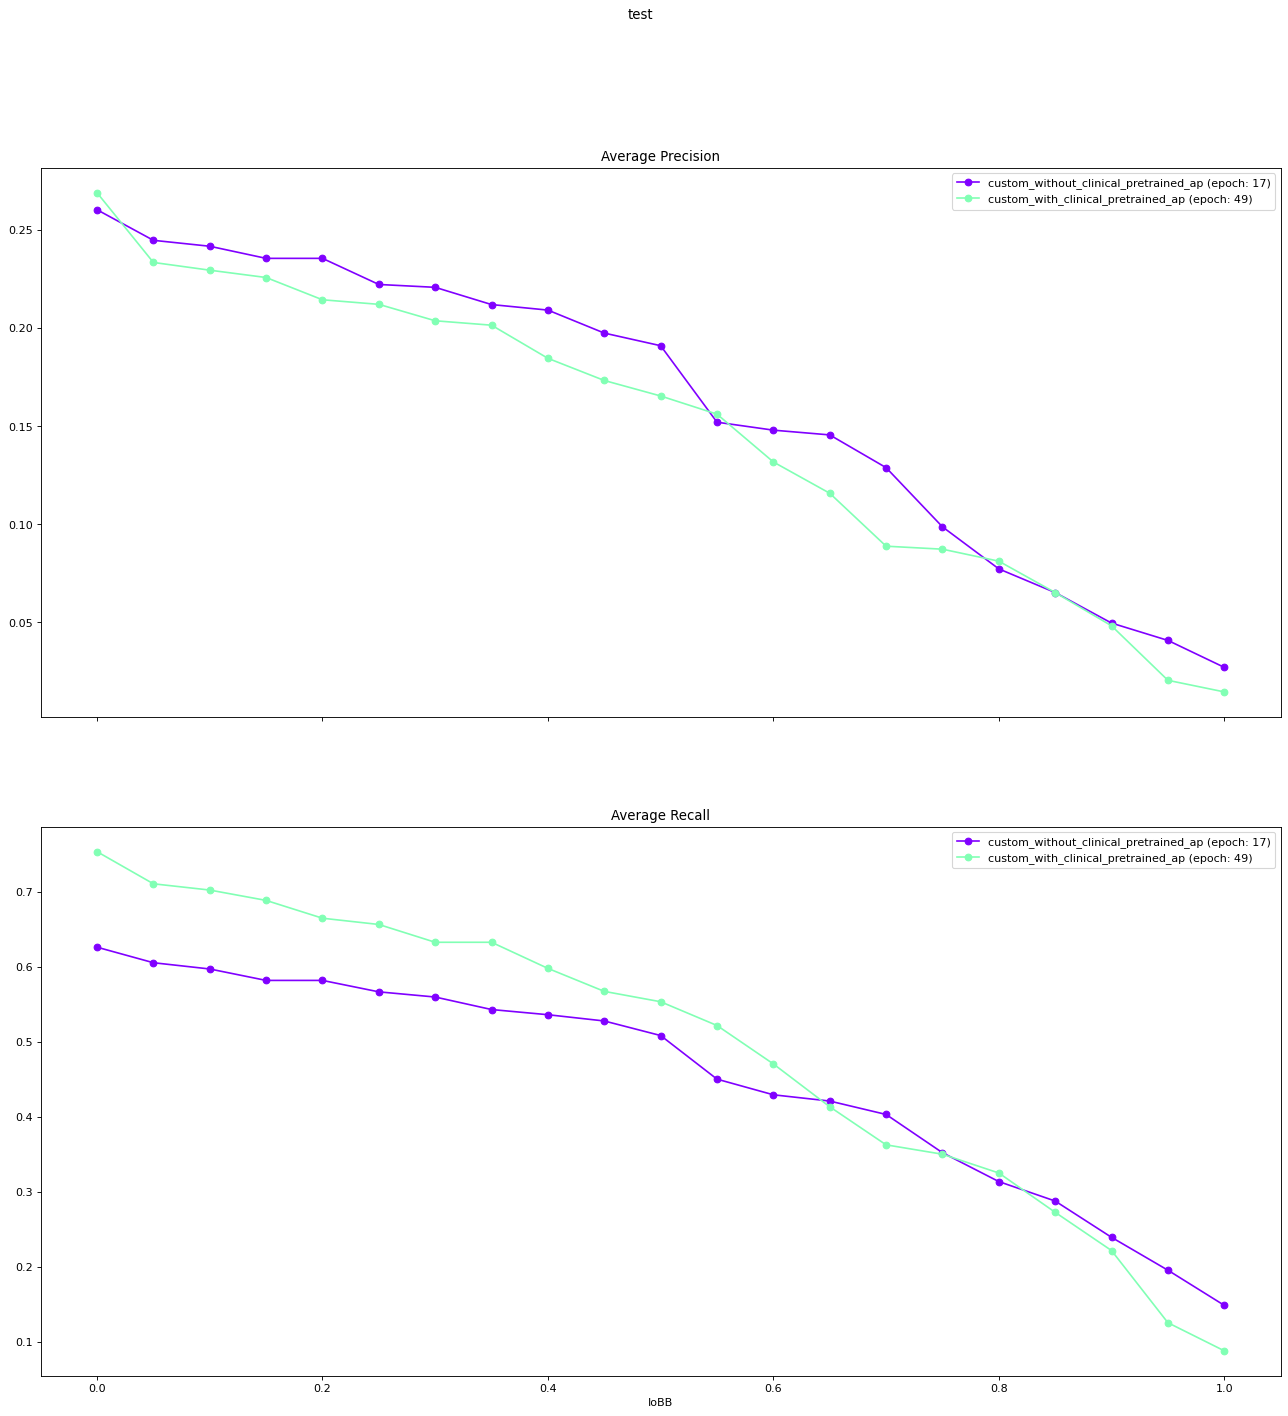

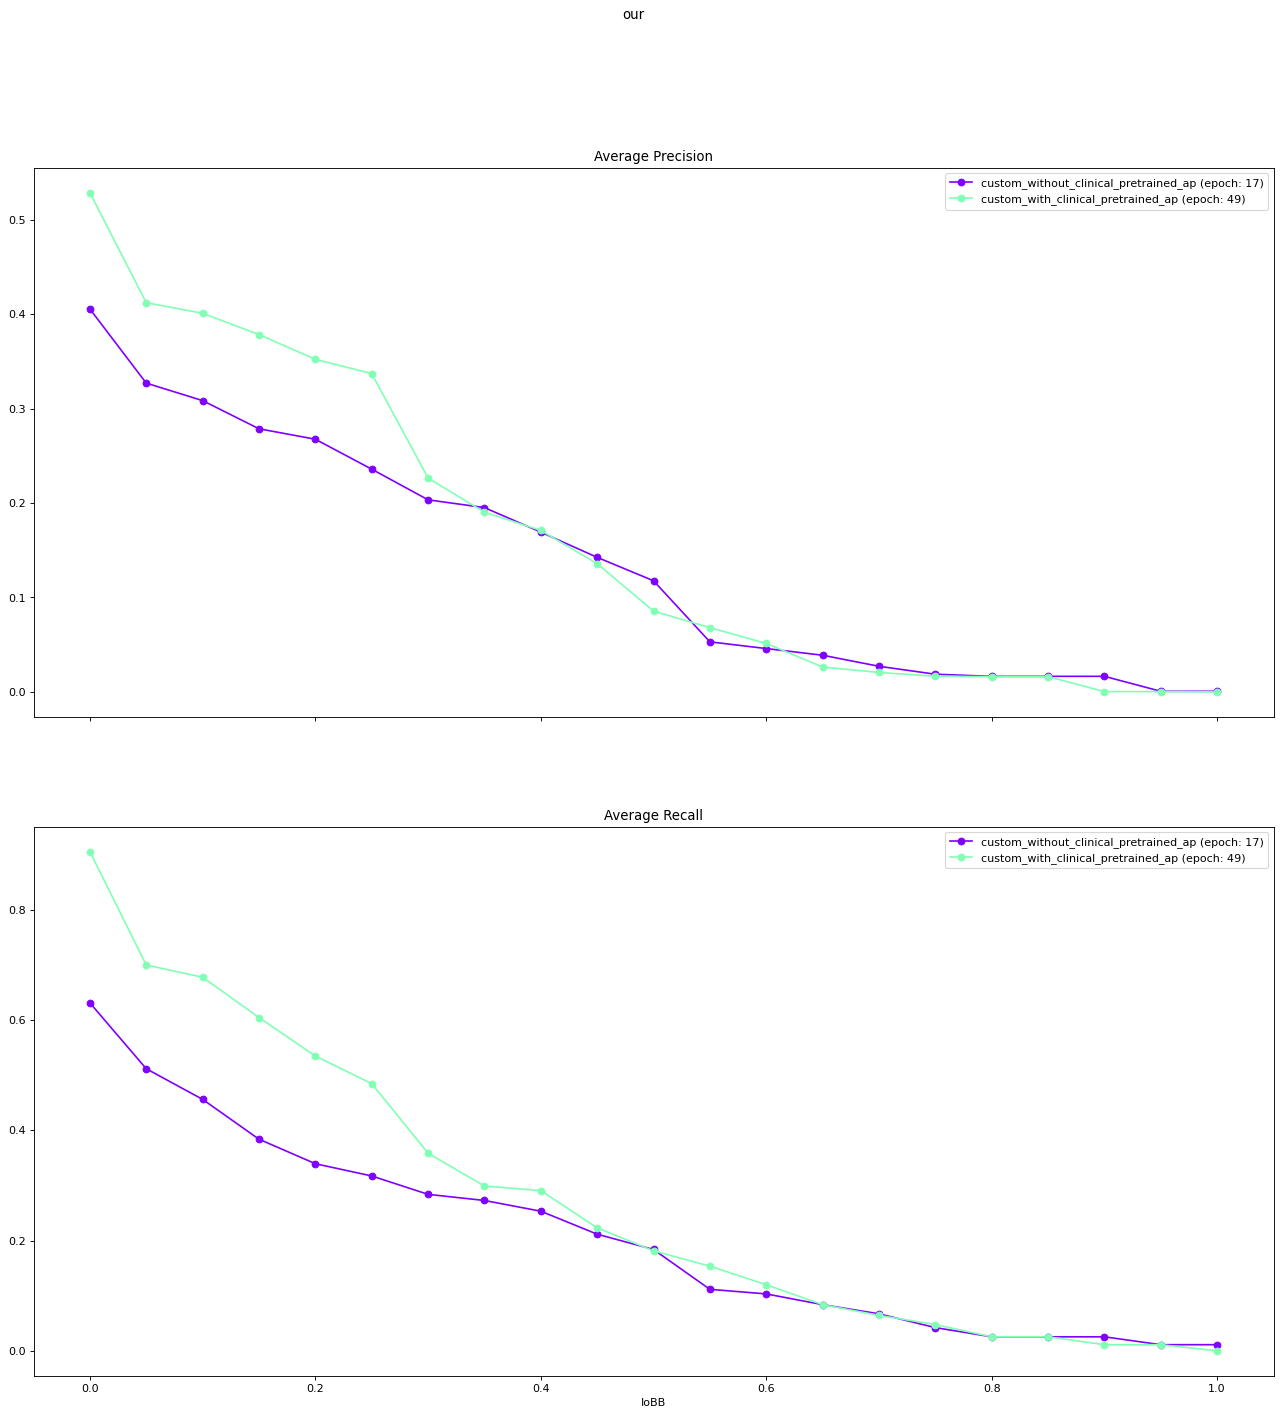

In [36]:
# Q: with clinicla / without clinical, whihch is better in pretrained model. 

clinical_varialbe_in_pretrained = [
    # TrainedModels.custom_without_clinical_pretrained_ar,
    TrainedModels.custom_without_clinical_pretrained_ap,
    # TrainedModels.custom_without_clinical_pretrained_final,

    # TrainedModels.custom_with_clinical_pretrained_ar,
    TrainedModels.custom_with_clinical_pretrained_ap,
    # TrainedModels.custom_with_clinical_pretrained_final,
]

_ = plot_iou_result(
    clinical_varialbe_in_pretrained, "train", figsize=(20, 20)
)
_ = plot_iou_result(
    clinical_varialbe_in_pretrained, "val", figsize=(20, 20)
)
_ = plot_iou_result(
    clinical_varialbe_in_pretrained, "test", figsize=(20, 20)
)
_ = plot_iou_result(
    clinical_varialbe_in_pretrained, "our", figsize=(20, 20)
)


# with clincial is best in validation, but without clincal works better in test.

# Q: with clinicla / without clinical, whihch is better in unpretrained model. 


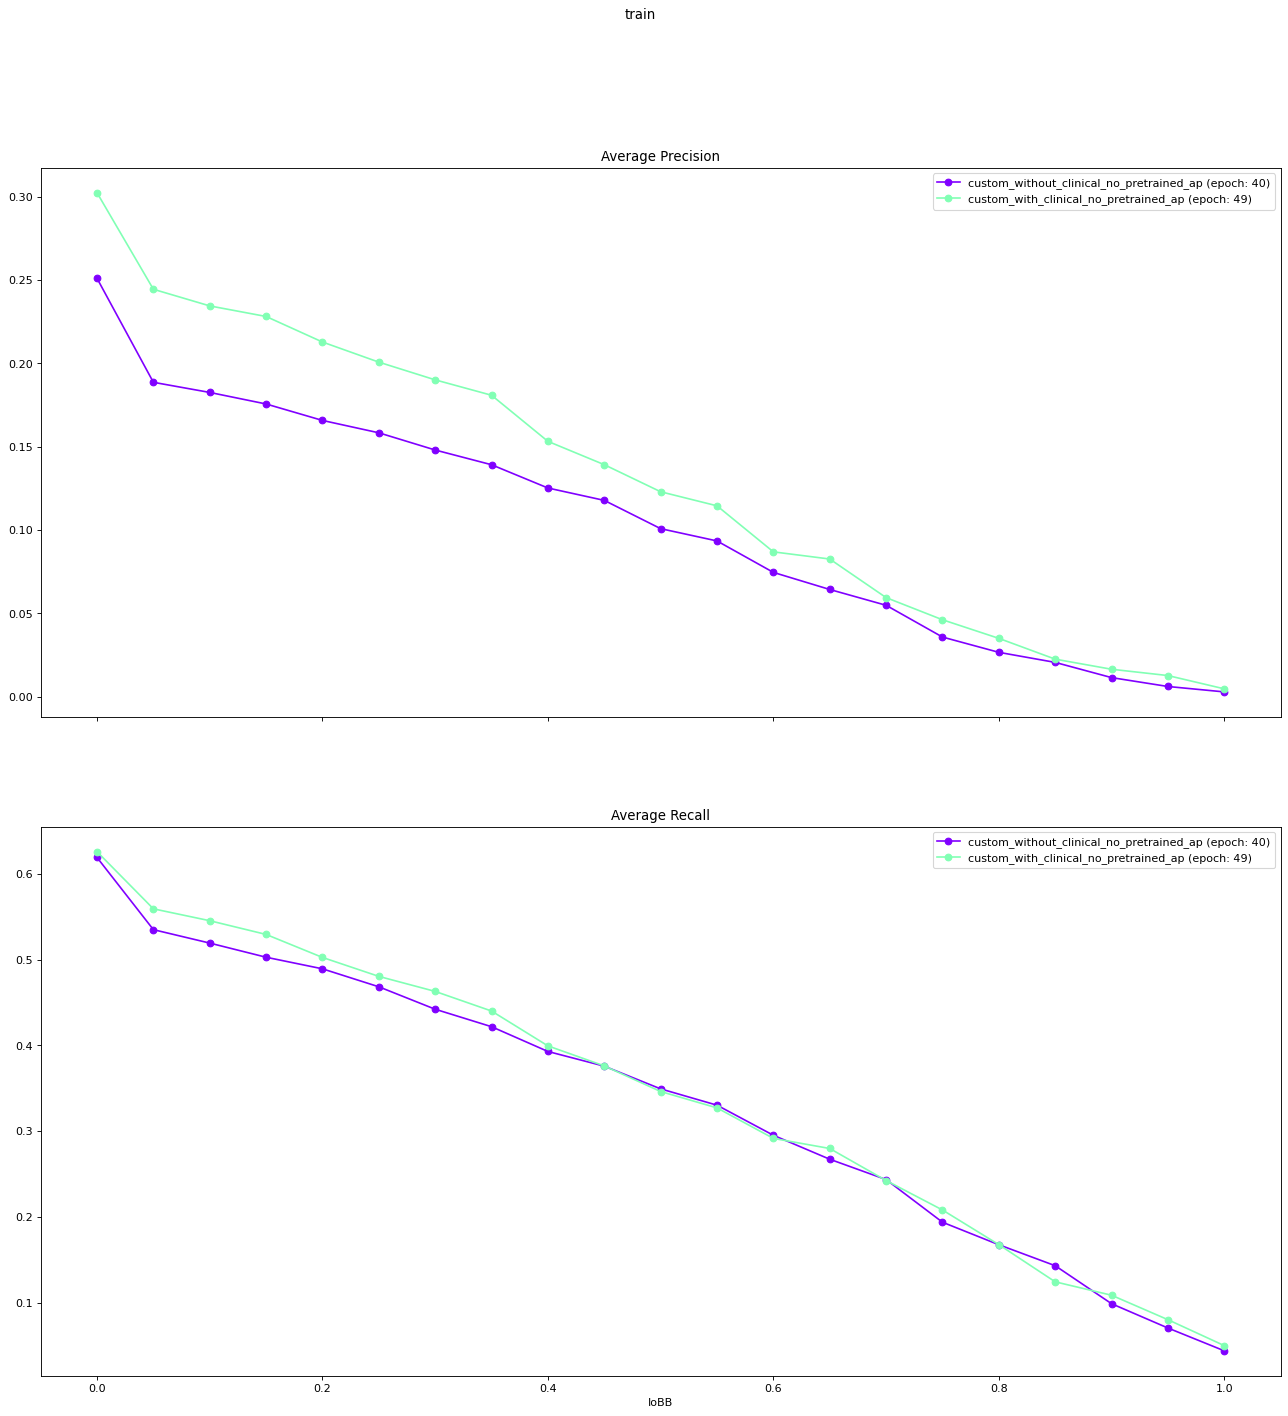

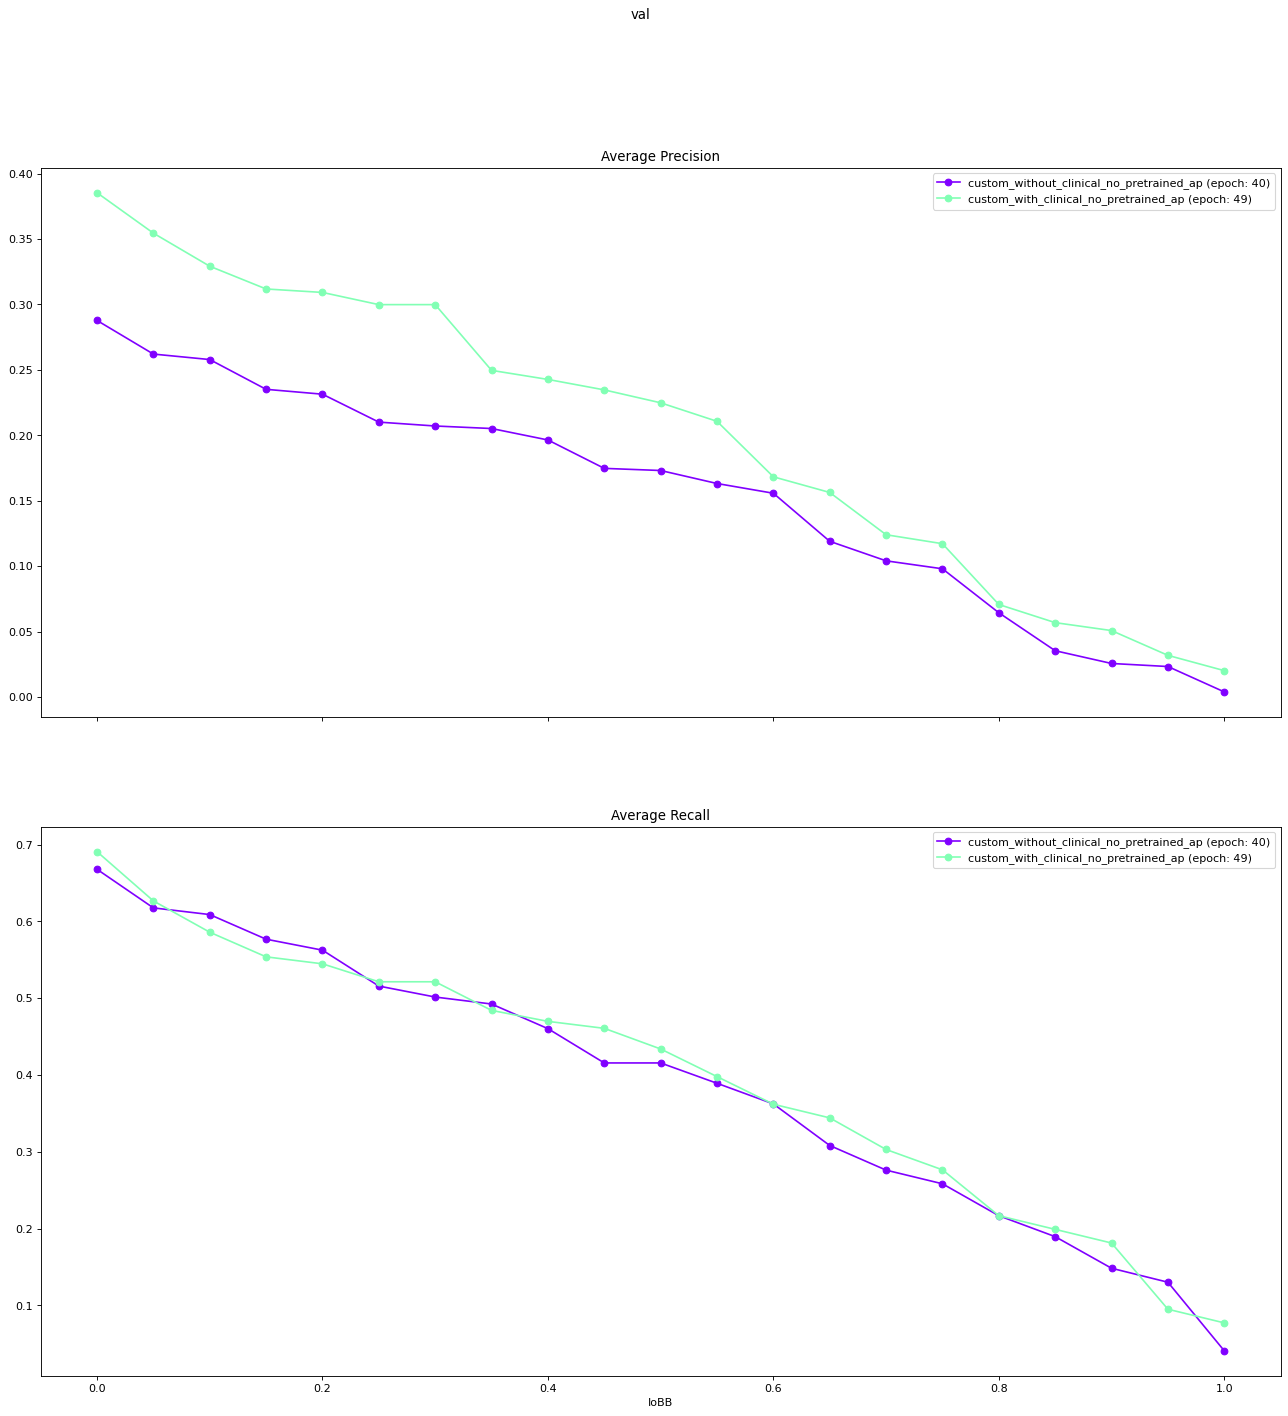

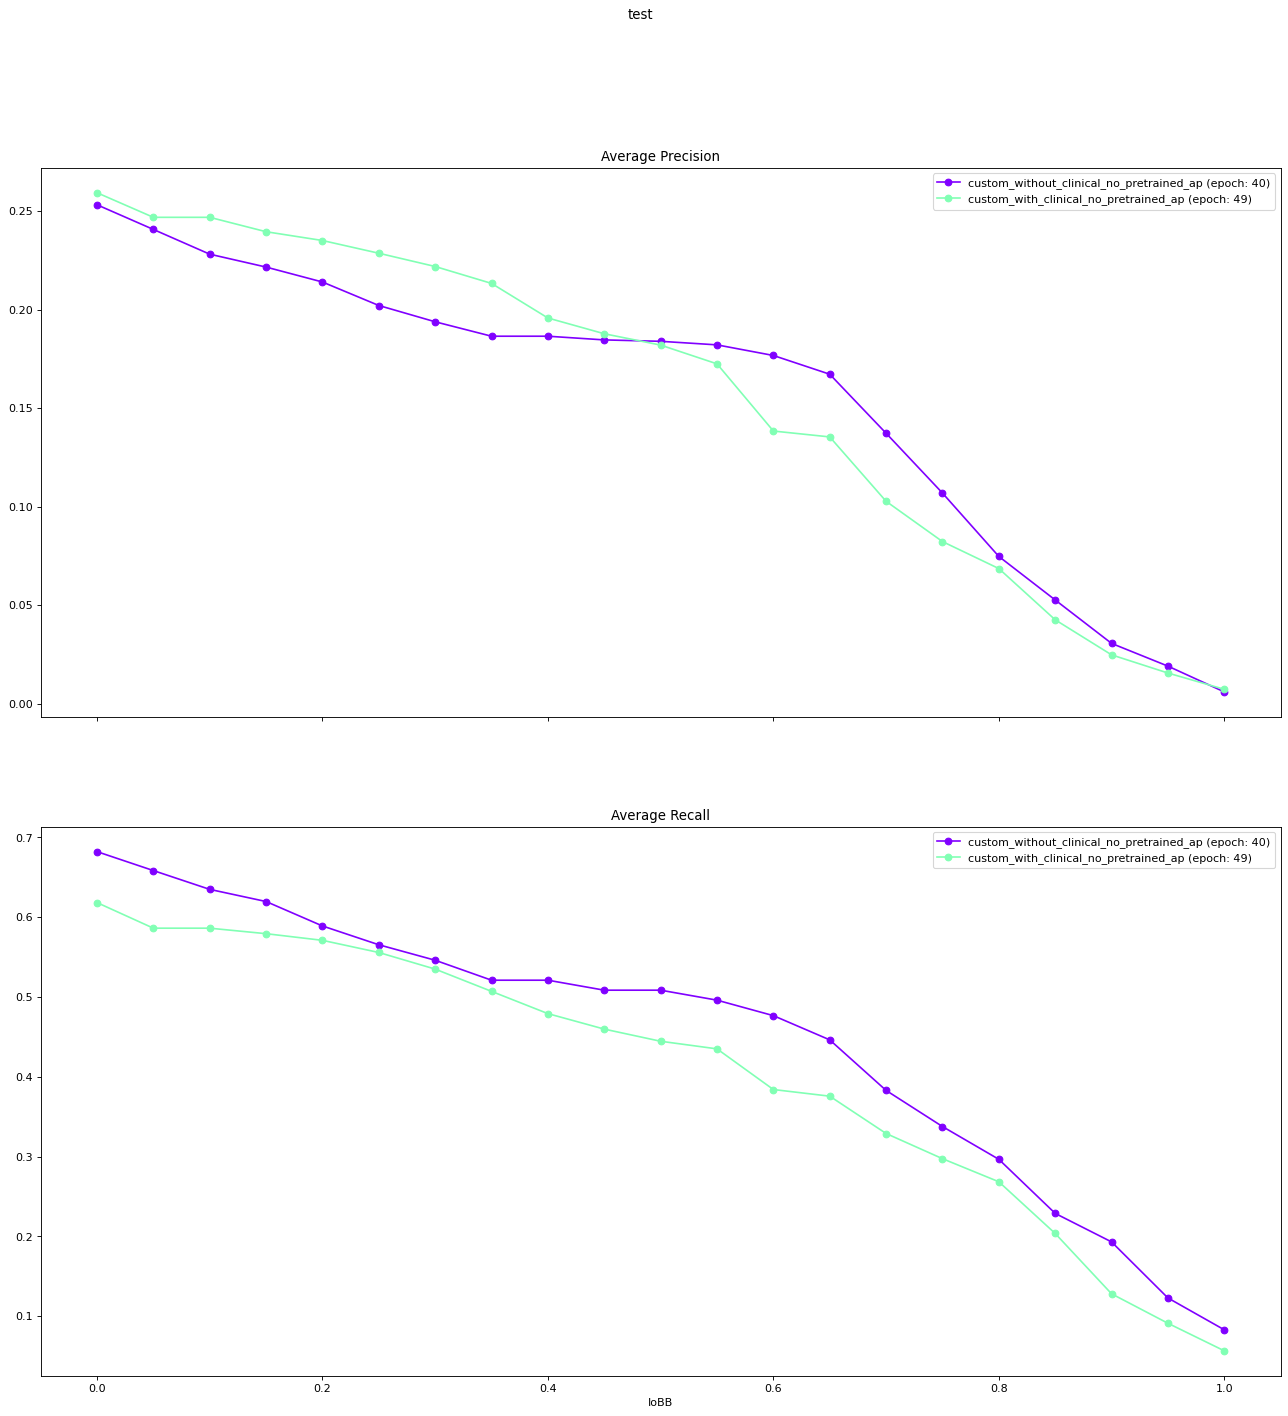

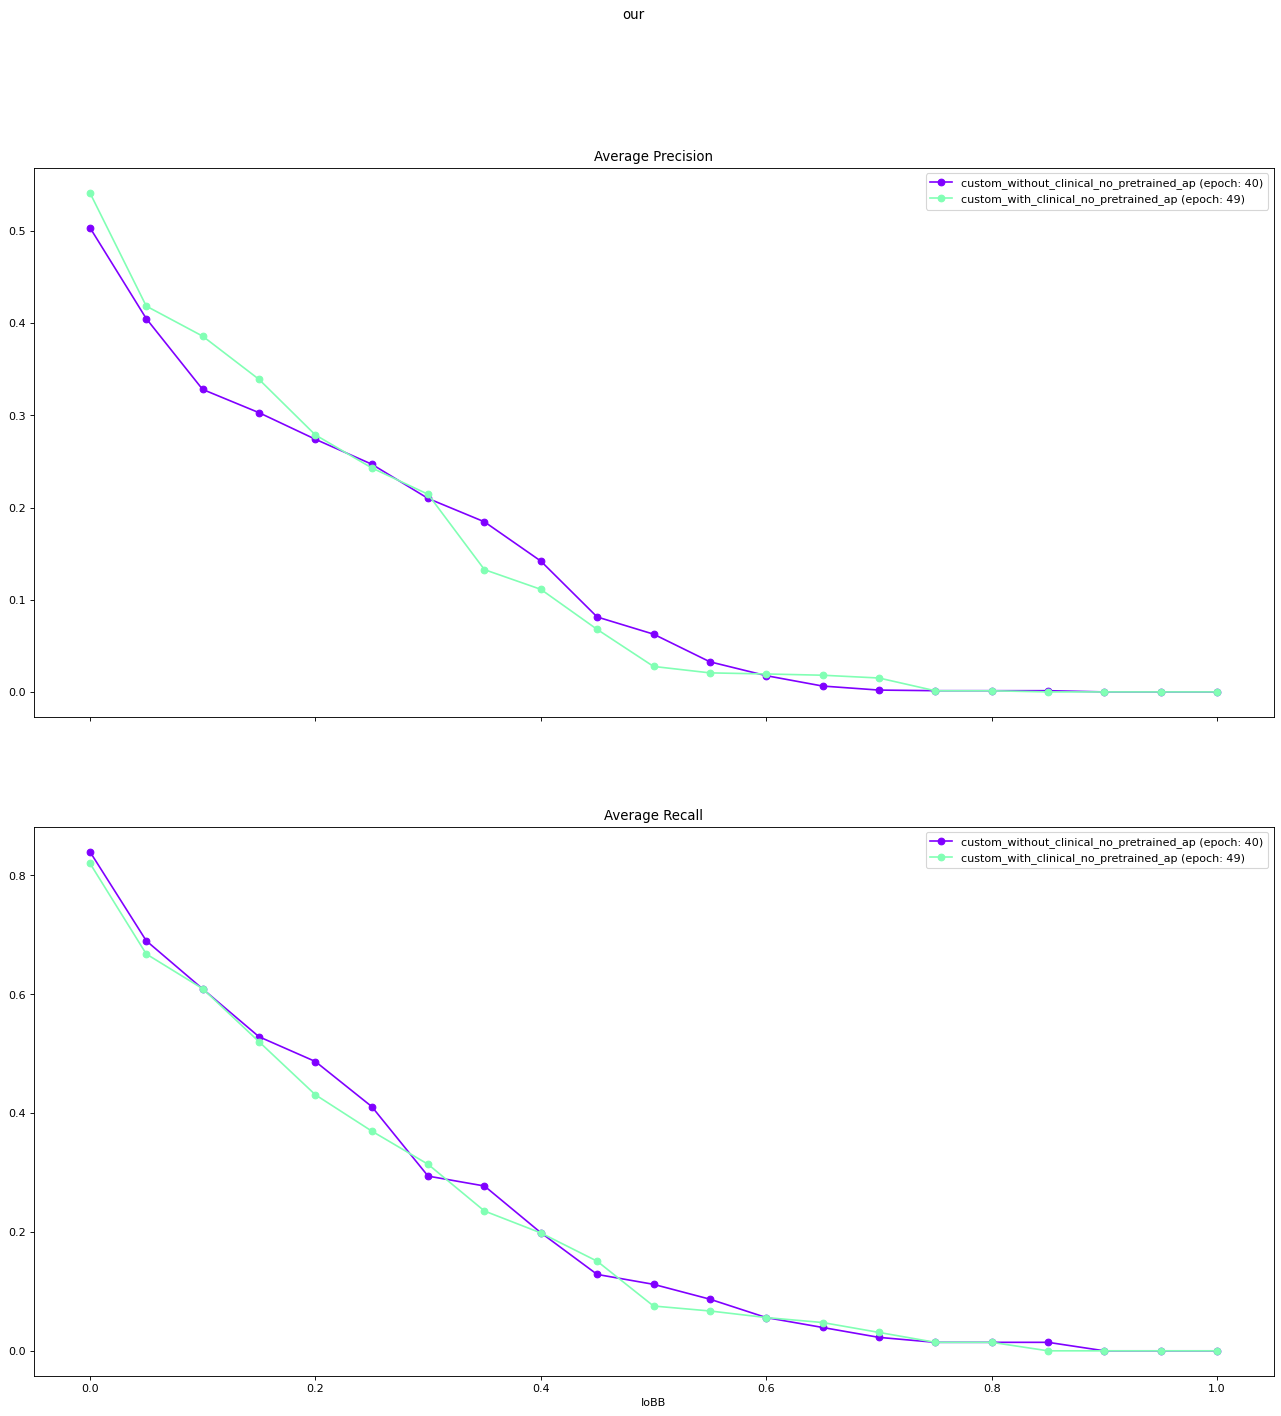

In [48]:

clinical_varialbe_in_pretrained = [
    # TrainedModels.custom_without_clinical_no_pretrained_ar,
    TrainedModels.custom_without_clinical_no_pretrained_ap,
    # TrainedModels.custom_without_clinical_no_pretrained_final,

    # TrainedModels.custom_with_clinical_no_pretrained_ar,
    TrainedModels.custom_with_clinical_no_pretrained_ap,
    # TrainedModels.custom_with_clinical_no_pretrained_final,
]

_ = plot_iou_result(
    clinical_varialbe_in_pretrained, "train", figsize=(20, 20)
)
_ = plot_iou_result(
    clinical_varialbe_in_pretrained, "val", figsize=(20, 20)
)
_ = plot_iou_result(
    clinical_varialbe_in_pretrained, "test", figsize=(20, 20)
)
_ = plot_iou_result(
    clinical_varialbe_in_pretrained, "our", figsize=(20, 20)
)


custom_with_clinical_no_pretrained_final
custom_without_clinical_no_pretrained_final


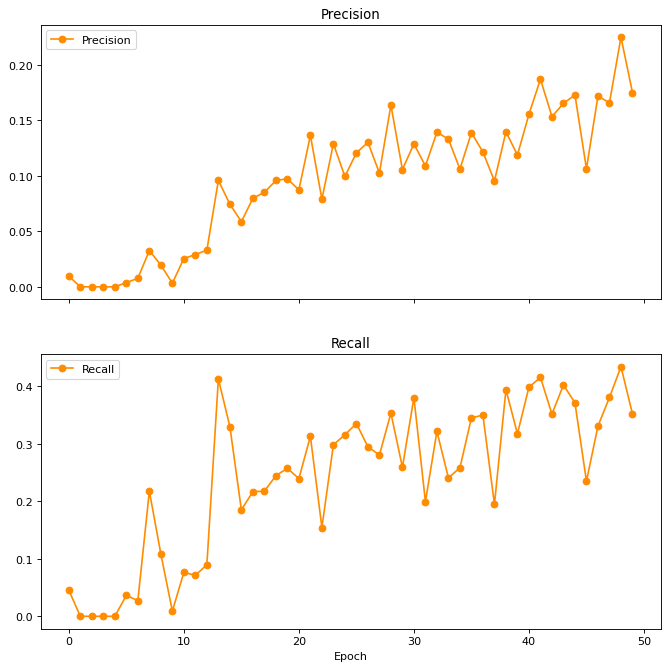

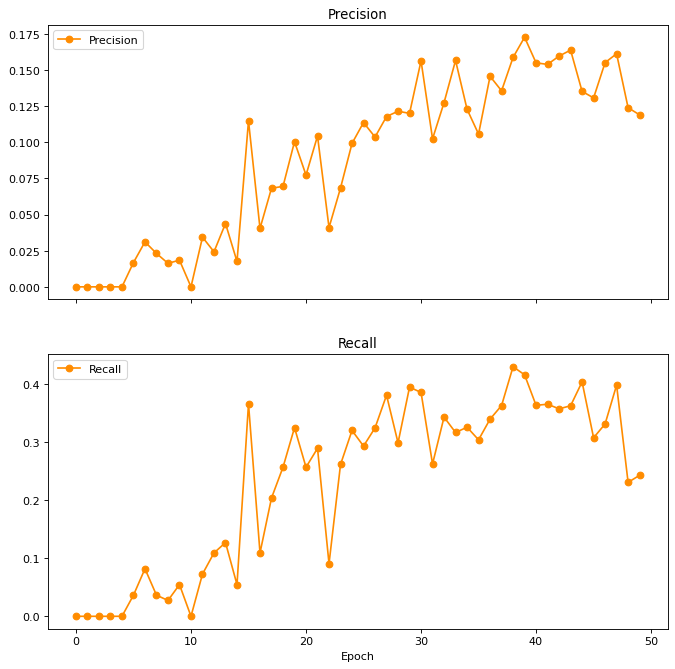

In [46]:
from utils.plot import plot_evaluator
from utils.save import TrainingInfo

# TrainedModels.custom_without_clinical_no_pretrained_ap,
# TrainedModels.custom_without_clinical_no_pretrained_ar,
# TrainedModels.custom_without_clinical_no_pretrained_final,


# TrainedModels.custom_without_clinical_pretrained_ap,
# TrainedModels.custom_without_clinical_pretrained_ar,
# TrainedModels.custom_without_clinical_pretrained_final,


# TrainedModels.custom_without_clinical_pretrained_ap,
# TrainedModels.custom_without_clinical_pretrained_ar,
# TrainedModels.custom_without_clinical_pretrained_final,

for select_model in [
    TrainedModels.custom_with_clinical_no_pretrained_final,
    TrainedModels.custom_without_clinical_no_pretrained_final,

]:
    with open(os.path.join("training_records", f"{select_model.value}.pkl"), "rb") as f:
        train_info: TrainingInfo = pickle.load(f)

    print(get_model_name(select_model))
    plot_evaluator(train_info.val_evaluators)


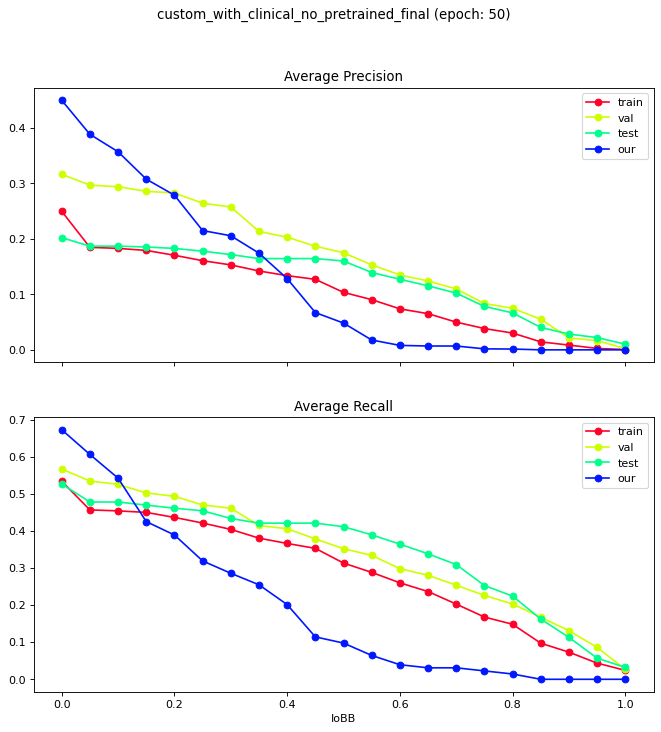

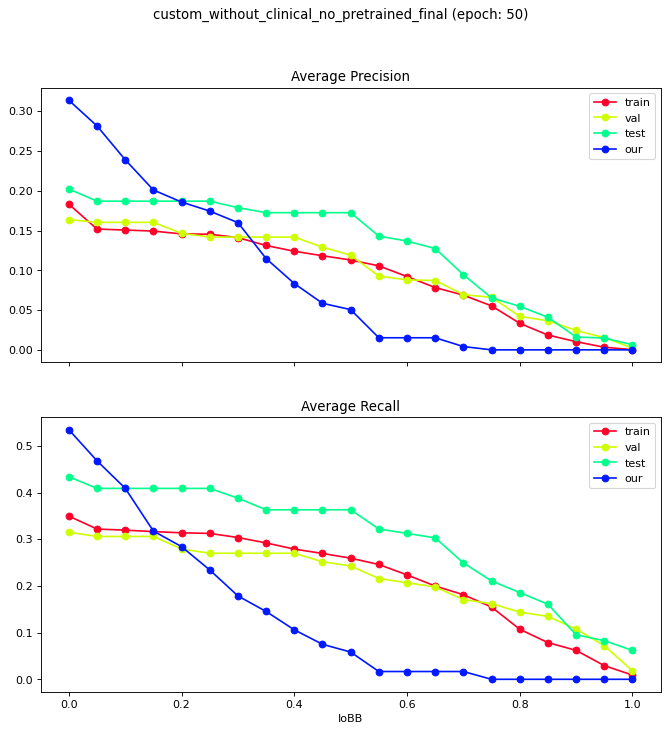

In [47]:
for select_model in [
    TrainedModels.custom_with_clinical_no_pretrained_final,
    TrainedModels.custom_without_clinical_no_pretrained_final,

]:
    _= showModelOnDatasets(
        select_model=select_model,
        datasets=['train','val', 'test', 'our'],
        disease='all',
    )